# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from difflib import SequenceMatcher
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, IntSlider

In [2]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import time
from selenium.webdriver.support.ui import WebDriverWait
import os.path
from bs4 import BeautifulSoup
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from sklearn.neighbors import KNeighborsClassifier

In [3]:
df = pd.read_csv('housing_data.csv')

In [4]:
df = df.drop('Unnamed: 0', axis = 1)

# EDA

In [5]:
def plot_col_distributions(col_list, 
                           graph_type, 
                           num_subplots, 
                           df = df, 
                           bins = 50,
                           order = None, 
                           fontsize = 12, 
                           figsize = (20, 20), 
                           rotation = 0):
    fig, axs = plt.subplots(num_subplots, figsize = figsize)
    if num_subplots == 1:
        axis = axs
    else:
        axis = axs[num_subplots - 1]
    for idx, col in enumerate(col_list):
        if graph_type == 'countplot':
            sns.countplot(x = col, data =df, ax = axis, order = order)
            axs.bar_label(axs.containers[0])
        elif graph_type == 'histplot':
            sns.histplot(x = col, data = df, ax = axis, bins = bins)
            axs.bar_label(axs.containers[0])
        axis.set_xlabel(col, fontsize = fontsize)
        axis.set_ylabel('Frequency', fontsize = fontsize)
        axis.tick_params(rotation = rotation)
    plt.show()
    plt.tight_layout

In [6]:
def is_not_outlier(series):
    iqr = series.quantile(0.75) - series.quantile(0.25)
    lq = series.quantile(0.25) - 1.5 * iqr
    uq = series.quantile(0.75) + 1.5 * iqr
    (series > lq) & (series < uq)
    return (series > lq) & (series < uq)

## General Info

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3745 entries, 0 to 3744
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          3745 non-null   int64  
 1   address        3745 non-null   object 
 2   property_type  3745 non-null   object 
 3   num_rooms      3745 non-null   float64
 4   floor_num      3745 non-null   float64
 5   meters         3745 non-null   int64  
 6   parking        2430 non-null   float64
 7   street         3741 non-null   object 
 8   city           3741 non-null   object 
dtypes: float64(3), int64(2), object(4)
memory usage: 263.4+ KB


<b>Comments</b>
1. Price is correct as an integer and has no null values.
2. Address is correct as a string and has no null values.
3. num_rooms of rooms is correct as a float since there is the possibility for half rooms.
4. floor_num is correct as a float since you can also be on a half floor, but we will change this to a whole number so that there are less values. Half floors do not make as much of a differnece.
5. Meters is fine as an integer. There are no null values.
6. Parking can be changed to an integer, but first null values will be filled with '0', as one can assume that if the parking is not listed as an option, it does not exist.
7. Street and City are correct as strings. There are 3 null values. The cities will be manually extracted from the address.

## Analyze/Clean Individual Features

### City

#### Update city

- Check for unique city names to see if they are spelled properly or if there are duplicates.

In [8]:
city_lists = df.city.unique()

In [9]:
city_lists

array(['Rishon LeTsiyon', 'Tel Aviv-Yafo', 'Bat Yam', 'Ramat Gan',
       'Netanya', 'Ashkelon', 'Beer Sheva', 'Mazkeret Batya', 'Sderot',
       'Holon', 'Jerusalem', nan, 'Beer Yaakov', 'Tiberias', 'Rehovot',
       'Petah Tikva', 'Lod', 'Beersheba', 'Herzliya', 'Haifa',
       'Migdal HaEmek', 'Ramla', 'Ashdod', 'Hod Hasharon', 'Nesher',
       'Yokneam Illit', 'feinberg', 'Azor', 'Yavne', 'Gedera',
       'Tirat Carmel', 'Gan Yavne', 'באר שבע', 'Or Yehuda', 'Ness Ziona',
       'Tel Aviv', 'Ariel', 'Kiryat Yam', 'Nahariya', 'Caesarea',
       'Hadera', 'Beit Zait', 'Givat Zeev', 'Nehalim', 'Bnei Brak',
       'Pardes Hanna-Karkur', 'Zikhron Yaakov', 'Givat Shmuel',
       'Givatayim', 'Ganei Tikva', 'Neria', 'Kdumim', 'Karnei Shomron',
       'אריאל', 'Eilat', 'Lehavim', 'Kiryat Ekron', 'Tverya',
       'Kiryat Bialik', 'Rosh Haayin', 'Yehud-Monosson', 'Ramat Yishai',
       'Kfar Baruch', 'Alonei Abba', 'אפרת', 'Kfar Yona', 'Even Yehuda',
       'Afula', 'Nahariyya', 'Acre', 'Yeru

- We can see that there are repeated city names because they are spelled slightly differently.
- We will use a sequence matcher to find similar name pairs and change them into one name.

In [10]:
city_pairs = []
for i in range(len(city_lists)):
    for j in range(i + 1, len(city_lists) + 1):
        # Do try/except because of the nan values.
        try:
            if SequenceMatcher(None, city_lists[i], city_lists[j]).ratio() > 0.7:
                city_pairs.append((city_lists[i], city_lists[j]))
        except:
            continue

In [11]:
city_pairs

[('Tel Aviv-Yafo', 'Tel Aviv'),
 ('Bat Yam', 'Kiryat Yam'),
 ('Beer Sheva', 'Beersheba'),
 ('Yavne', 'Gan Yavne'),
 ('Kiryat Yam', 'Kiryat Ata'),
 ('Kiryat Yam', 'Kiryat Gat'),
 ('Nahariya', 'Nahariyya'),
 ('Hadera', 'Hamra'),
 ('Nehalim', 'Lehavim'),
 ('Pardes Hanna-Karkur', 'Pardes Hana-Karkur'),
 ('Ramat Yishai', 'Ramat Yishay'),
 ('Raanana', 'Ra`anana'),
 ('Kiryat Ata', 'Kiryat Gat')]

- Some of the city pairs are not the same. We will hand select indices of pairs that are relevant. Unfortunately this needs to be done with a human eye.

In [12]:
indices_of_pairs = [0, 2, 6, 9, 10, 11]

In [13]:
def unify_city(city, indices_of_pairs):
    for idx in indices_of_pairs:
        if city in city_pairs[idx]:
            city = city_pairs[idx][0]
            return city
        else:
            continue
    return city

In [14]:
df['city'] = df.city.apply(unify_city, args = (indices_of_pairs,))

In [15]:
df[df['city'].isna()]

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
37,6700000,Derech HaZayit Kfar Shmuel,Apartment,6.0,3.0,350,3.0,NaN,NaN
2311,1520000,Through a beacon Ma'ale Efrayim,Cottage/house,4.0,1.0,77,NaN,NaN,NaN
2776,1500000,Rifts Bekaot,Villa,5.0,1.0,122,NaN,NaN,NaN
2989,1300000,578 Migdalim,Villa,3.0,1.0,85,NaN,NaN,NaN


#### Distribution

In [16]:
print(f'There are {len(df.city.unique())} cities that have listings on onmap.')

There are 106 cities that have listings on onmap.


In [17]:
print(f'There are {len(df.city.value_counts()[df.city.value_counts()>=10])} cities that have more than 10 listings.')

There are 29 cities that have more than 10 listings.


In [18]:
print(f'There are {len(df.city.value_counts()[df.city.value_counts()<10])} cities that have less than 10 listings.')

There are 76 cities that have less than 10 listings.


In [19]:
print(f'There are {len(df.city.value_counts()[df.city.value_counts()==1])} cities that have only one listing listings.')


There are 41 cities that have only one listing listings.


- Since we are interesting in understanding regions, we will look at cities with at least 10 or more listings. That way, we can get a better understanding of the neighborhoods and which locations are the right ones for us to search.

In [20]:
order = df.groupby(by=["city"])['city'].count().sort_values(ascending = False).index

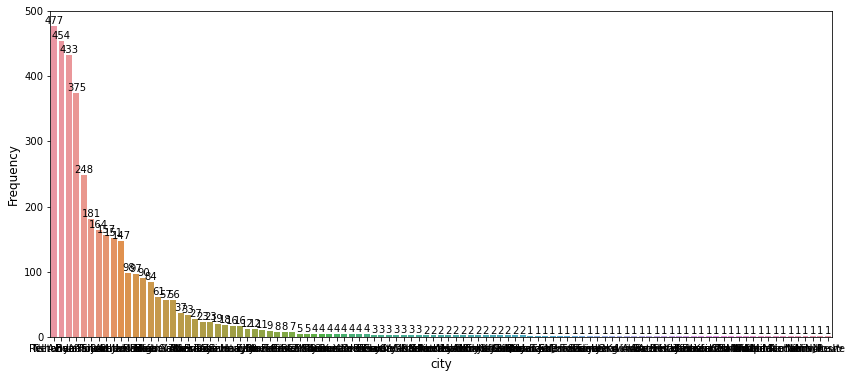

In [21]:
plot_col_distributions(['city'], 
                       'countplot', 
                       num_subplots = 1, 
                       figsize = (14, 6),
                      order = order)

The graph above shows that there is a very large tail of single sale listings. We will filter out the cities that have less than 10 listings to get a clearer view of how many listings there are for more major cities.

In [22]:
order = df.groupby('city').filter(lambda x: len(x) > 10).groupby(by=["city"])['city'].count().sort_values(ascending = False).index

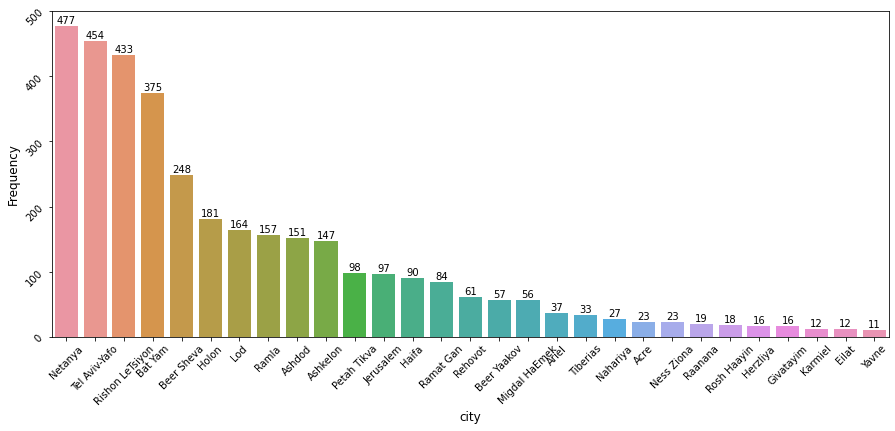

In [23]:
plot_col_distributions(col_list = ['city'], 
                       graph_type = 'countplot', 
                       order = order,
                       df = df.groupby('city').filter(lambda x: len(x) > 10), 
                       num_subplots = 1, figsize = (15, 6),
                       rotation = 45)

- Netanya, Tel Aviv, and Rishon LeTsiyon have the most listings. This will make them more interesting in this study, and the information that we gather about those neighborhoods will be more reliable.

#### Explore null values

In [24]:
print('{:.2%} of the values are null in the city column.'.format(df.city.isna().mean()))

0.11% of the values are null in the city column.


In [25]:
df[df.city.isna()]

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
37,6700000,Derech HaZayit Kfar Shmuel,Apartment,6.0,3.0,350,3.0,NaN,NaN
2311,1520000,Through a beacon Ma'ale Efrayim,Cottage/house,4.0,1.0,77,NaN,NaN,NaN
2776,1500000,Rifts Bekaot,Villa,5.0,1.0,122,NaN,NaN,NaN
2989,1300000,578 Migdalim,Villa,3.0,1.0,85,NaN,NaN,NaN


- After looking at the above results, these can be manually filled in.

In [26]:
df.loc[df.address == 'Derech HaZayit Kfar Shmuel', 'city'] = 'Kfar Shmuel'

In [27]:
df.loc[df.address == "Through a beacon Ma'ale Efrayim", 'city'] = "Ma'ale Efrayim"

In [28]:
df.loc[df.address == "Rifts Bekaot", 'city'] = "Bekaot"

In [29]:
df.loc[df.address == "578 Migdalim", 'city'] = "Migdalim"

### Number of rooms

In [30]:
print('{:.2%} of the values are null in the num_rooms column.'.format(df.num_rooms.isna().mean()))

0.00% of the values are null in the num_rooms column.


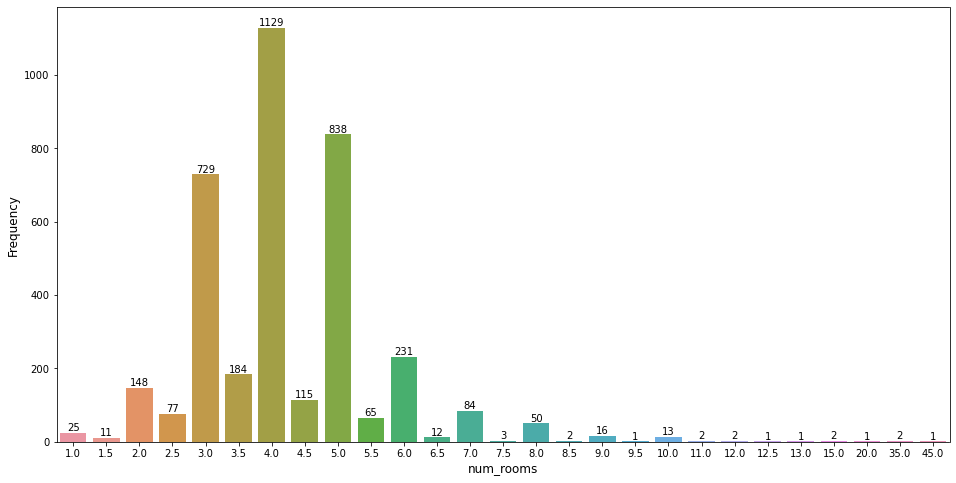

In [31]:
plot_col_distributions(['num_rooms'], 'countplot', num_subplots = 1, figsize = (16, 8))

- The most common type of apartment is a 4 room apartment, which is great, because this is what we are searching for.
- It seems that the most people selling homes are families, based on the number of rooms.
- It seems extremely unlikely that an apartment could have 35 or 45 rooms. I will check on all apartments that have 15 or more rooms.

In [32]:
df[df.num_rooms >= 15]

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
183,1440000,"Dov Hoz St. 8,Netanya",Garden apt.,45.0,0.0,100,NaN,Dov Hoz St.,Netanya
1082,21500000,Neve Tzedek St. Tel Aviv,Apartment,15.0,0.0,500,NaN,Neve Tzedek St.,Tel Aviv-Yafo
1376,1450000,Khativat Givati St. Ashdod,Garden apt.,35.0,0.0,70,NaN,Khativat Givati St.,Ashdod
2264,777000,"David HaMelech St. 3,Beer Sheva",Apartment,35.0,4.0,60,2.0,David HaMelech St.,Beer Sheva
2932,9700000,Ha-Tamar St. Rishon LeTsiyon,Cottage/house,15.0,3.0,400,2.0,Ha-Tamar St.,Rishon LeTsiyon
3585,4200000,Louis HaTshii St. Acre,Apartment,20.0,0.0,700,NaN,Louis HaTshii St.,Acre


- It looks like the listing in Netanya should have been 4.5 rooms.
- The listings in Ahsdod and Beer Sheva should be 3.5 rooms.

In [33]:
df.loc[183, 'num_rooms'] = 4.5
df.loc[1376, 'num_rooms'] = 3.5
df.loc[2264, 'num_rooms'] = 3.5

### Floor number

In [34]:
print('{:.2%} of the values are null in the floor number column.'.format(df['floor_num'].isna().mean()))

0.00% of the values are null in the floor number column.


- There are no null values for floor number
- Half floors can be ignored for this task, since they do not make much of a difference in value of an apartment, but do make the data messier.

In [35]:
df['floor_num'] = df['floor_num'].astype('int')

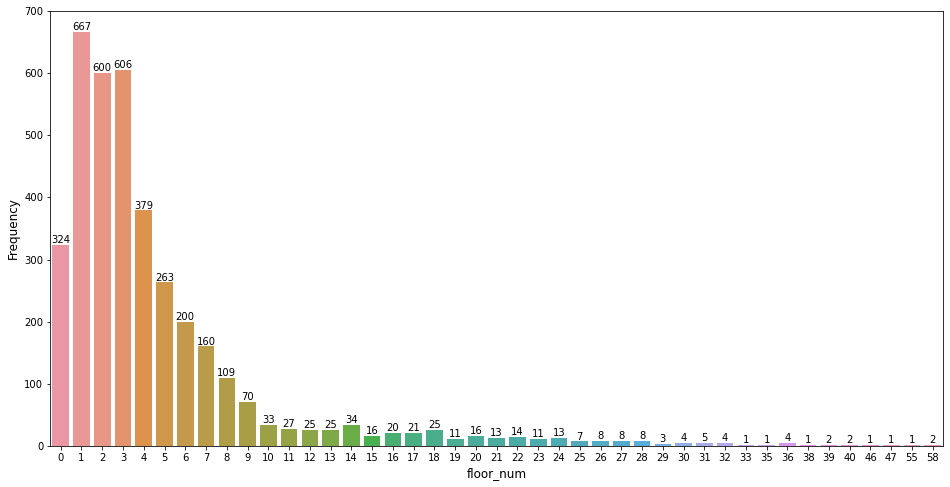

In [36]:
plot_col_distributions(['floor_num'], 'countplot', rotation = 0, num_subplots = 1, figsize = (16, 8))

- Most apartments are on the first through third floor. This possibly implies that there are many units sold in non high-rise buildings, which is encouraging.

### Property Type

In [37]:
print('{:.0%}% of the listings have null values for property type.'.format(df.property_type.isna().mean()))

0%% of the listings have null values for property type.


In [38]:
order = df['property_type'].value_counts().index

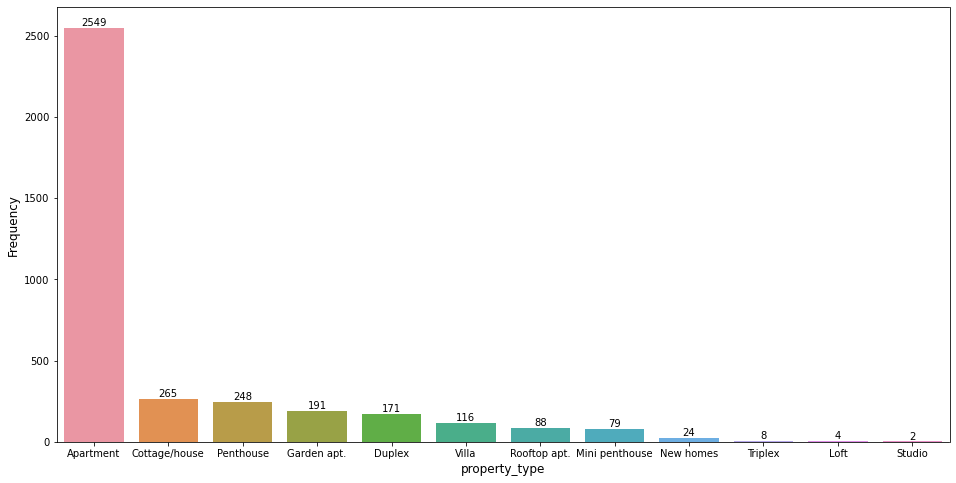

In [39]:
plot_col_distributions(['property_type'], 
                       'countplot', 
                       num_subplots = 1, 
                       figsize = (16, 8),
                      order = order)

- Unsurprisingly most listings are for apartments. There are still around 10% of the listings that are houses.

### Parking

#### Fill Null Values

In [40]:
print('{:.0%}% of the listings have null values for parking.'.format(df.parking.isna().mean()))

35%% of the listings have null values for parking.


- Which cities have null values for parking?

In [41]:
df[df.parking.isna()].city.value_counts()

Tel Aviv-Yafo      201
Bat Yam            185
Beer Sheva         112
Netanya            102
Rishon LeTsiyon     86
Lod                 86
Holon               75
Ramla               66
Haifa               58
Jerusalem           51
Ashdod              40
Ashkelon            30
Ramat Gan           30
Petah Tikva         24
Acre                17
Migdal HaEmek       17
Tiberias            17
Rehovot             16
Ariel               16
Givatayim            8
Nahariya             7
Bnei Brak            7
Karmiel              7
Eilat                5
Ness Ziona           5
Beer Yaakov          3
Eli                  3
Ramat Hasharon       3
Rosh Haayin          3
Yavne                3
Nesher               2
Mazkeret Batya       2
Bekaot               1
Raanana              1
Hatzor HaGlilit      1
עמנואל               1
Modiin Ilit          1
Pardesiya            1
Harish               1
Kiryat Motzkin       1
Immanuel             1
Migdalim             1
Bet Shemesh          1
Neria      

- Many of these cities will likely not have parking with the building. Therefore, these null values will be filled with 0. It is possible though that parking was just not listed on the main gallery.

In [42]:
df['parking'] = df['parking'].fillna(0).astype('int')

#### Distribution

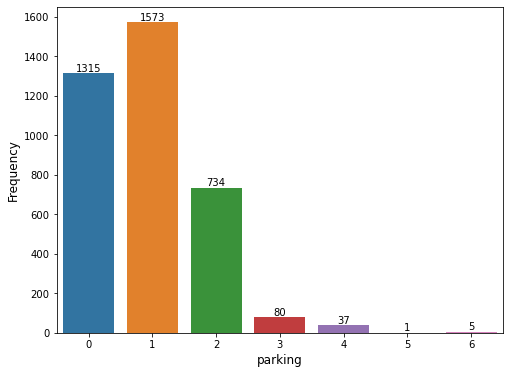

In [43]:
plot_col_distributions(['parking'], 'countplot', num_subplots = 1, figsize = (8, 6))

- Most of the apartments have at least one parking space for the unit. This is good because parking is a non-negotiable.
- It seems bizarre to have more than 3 parking spaces for a unit.

In [44]:
df[df['parking']>3].head()

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
2,11900000,"Rothschild Boulevard 17,Tel Aviv-Yafo",Apartment,5.0,6,165,4,Rothschild Boulevard 17,Tel Aviv-Yafo
440,2590000,Moshe Levi Ramla,Apartment,5.0,5,135,4,MosheLevi,Ramla
447,11000000,"Yitshak Sadeh St. 8,Bat Yam",Penthouse,6.0,35,320,4,Yitshak Sadeh St.,Bat Yam
467,3600000,Meir Dankner St. Petah Tikva,Apartment,4.5,1,120,4,Meir Dankner St.,Petah Tikva
637,13000000,"Ha-Shamayim St. 25,Caesarea",Villa,8.0,3,400,6,Ha-Shamayim St.,Caesarea


- It is not obvious what the values for number of parking spaces should be. Therefore, we will leave the values. It is more important anyways, whether there is parking at all.

### Meters

In [45]:
print('{:.0%} of the listings have null values for meters.'.format(df.meters.isna().mean()))

0% of the listings have null values for meters.


In [46]:
df.meters.describe()

count    3.745000e+03
mean     8.196660e+02
std      4.232113e+04
min      1.000000e+00
25%      8.300000e+01
50%      1.060000e+02
75%      1.400000e+02
max      2.590000e+06
Name: meters, dtype: float64

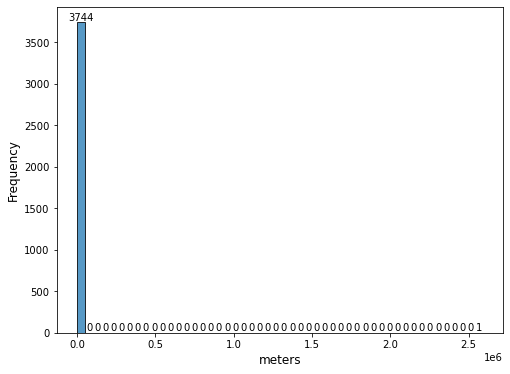

In [47]:
plot_col_distributions(['meters'], 'histplot', num_subplots = 1, figsize = (8, 6))

- Due to the outliers in the graph, we cannot view the distribution. We will explore the outliers.

In [48]:
df[~is_not_outlier(df.meters)].sort_values(by = 'meters', ascending = False).head(25)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
2762,2590000,"Mordekhai Moteleh Rosenstein St. 8,Rishon LeT...",Apartment,5.0,2,2590000,1,Mordekhai Moteleh Rosenstein St.,Rishon LeTsiyon
2929,2600000,"Irus ha-Argaman St. 44,Netanya",Duplex,4.0,3,11419,1,Irus ha-Argaman St.,Netanya
1294,35000000,Tsahal St. Tel Aviv-Yafo,Villa,10.0,3,1250,6,Tsahal St.,Tel Aviv-Yafo
1983,3890000,Yerushalayim St. Bat Yam,Apartment,5.0,2,1250,1,Yerushalayim St.,Bat Yam
3074,8190000,Divrei Khayim St. Netanya,Villa,4.0,1,1058,0,Divrei Khayim St.,Netanya
719,2860000,Ha-Brosh St. Beer Yaakov,Apartment,4.0,18,1000,2,Ha-Brosh St.,Beer Yaakov
2509,1390000,Herzl St. Nahariyya,Apartment,3.0,4,953,1,Herzl St.,Nahariya
652,37000000,"Shlomo ha-Melekh St. 4,Herzliya",Villa,8.0,3,700,2,Shlomo ha-Melekh St.,Herzliya
3585,4200000,Louis HaTshii St. Acre,Apartment,20.0,0,700,0,Louis HaTshii St.,Acre
2731,7250000,"Sigalon St. 16,Lod",Apartment,7.0,0,700,1,Sigalon St.,Lod


**Comments**
1. Idx 2762 is not possible. It should be dropped.
2. Idx 2929, 1983, 719, 2509 perhaps should have their meters divided by 100 and 10 respectively.
3. Idx 3074 should be dropped. 3074 should cost more for that size of a place.
4. Idx 1134 and 1734 are unrealistic listings and should be dropped. It is impossible that for there to be one room for such a large space.

In [49]:
df.drop([2762, 3074, 1736, 1134], axis = 0, inplace = True)

In [50]:
df.loc[[2929], 'meters'] = df.loc[[2929], 'meters']/100

In [51]:
df.loc[[1983, 719, 2509], 'meters'] = df.loc[[1983, 719, 2509], 'meters']/10

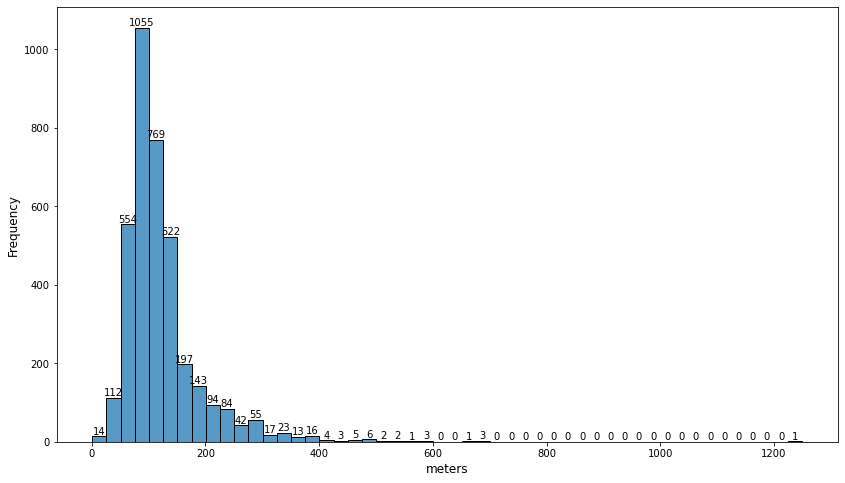

In [52]:
plot_col_distributions(['meters'], 'histplot', num_subplots = 1, figsize = (14, 8))

- Most places seem to be around 100 meters in size, which makes sense since most of the places are around 4 rooms. This is also great for our search, as we are looking for something at least 100m.

In [53]:
df.meters.describe()

count    3741.000000
mean      123.840548
std        71.760026
min         1.000000
25%        83.000000
50%       106.000000
75%       140.000000
max      1250.000000
Name: meters, dtype: float64

- This confirms the above statement.

### Price

In [54]:
df.price.describe()

count    3.741000e+03
mean     3.387856e+06
std      4.168887e+06
min      1.200000e+05
25%      1.750000e+06
50%      2.490000e+06
75%      3.740000e+06
max      1.320000e+08
Name: price, dtype: float64

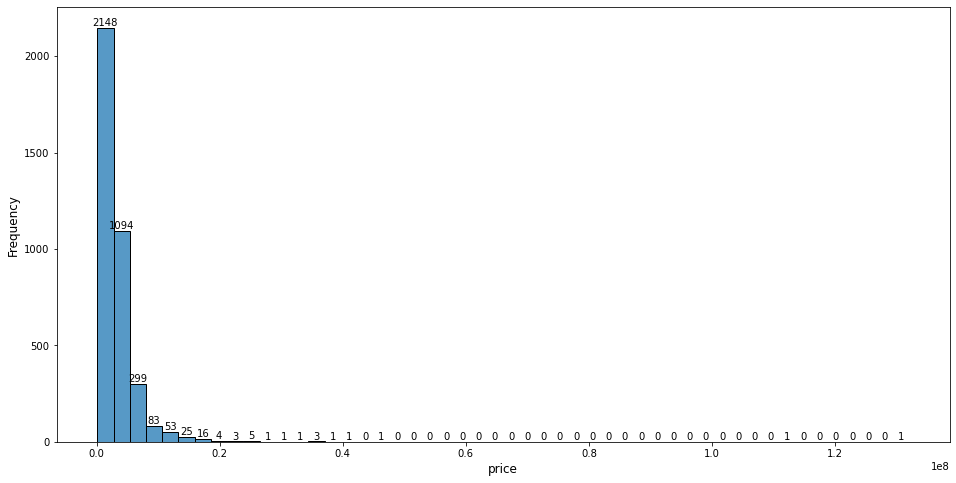

In [55]:
plot_col_distributions(['price'], 'histplot', num_subplots = 1, figsize = (16, 8))

- As can be seen above, there are also extreme outliers when it comes to price. We will look at the graph without outliers. We will also examine the outliers

In [56]:
df[~is_not_outlier(df.price)].sort_values(by = 'price', ascending = False).head(25)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city
3721,132000000,HaYarkon St. Tel Aviv-Yafo,Penthouse,4.0,23,400.0,3,HaYarkon St.,Tel Aviv-Yafo
2716,111111111,Alef Samech Levi St. Ramla,Apartment,3.0,4,71.0,0,Alef Samech Levi St.,Ramla
1931,45000000,Sderot Levi Eshkol Tel Aviv-Yafo,Penthouse,5.0,24,330.0,2,Sderot Levi Eshkol,Tel Aviv-Yafo
633,40000000,Ha-Eshel St. Herzliya,Villa,8.0,3,670.0,2,Ha-Eshel St.,Herzliya
1267,39000000,Ahavat Tsiyon St. Tel Aviv-Yafo,Villa,10.0,3,500.0,2,Ahavat Tsiyon St.,Tel Aviv-Yafo
2403,37000000,"Shlomo ha-Melekh St. 37,Herzliya",Villa,9.0,3,516.0,1,Shlomo ha-Melekh St.,Herzliya
652,37000000,"Shlomo ha-Melekh St. 4,Herzliya",Villa,8.0,3,700.0,2,Shlomo ha-Melekh St.,Herzliya
1294,35000000,Tsahal St. Tel Aviv-Yafo,Villa,10.0,3,1250.0,6,Tsahal St.,Tel Aviv-Yafo
1280,32000000,Merkaz Baalei Melaha St. Tel Aviv-Yafo,Duplex,6.0,5,215.0,2,Merkaz Baalei Melaha St.,Tel Aviv-Yafo
3718,30000000,Rothschild Boulevard Tel Aviv-Yafo,Penthouse,4.0,6,308.0,2,Rothschild Boulevard,Tel Aviv-Yafo


<b> Comments </b>
- Most of the outliers for price are villas or are in Tel Aviv.
- The apartment in Ramla with index 2716 has to be incorrect. It is over an 11 mill apartment for 70 meters.
- The place in Tel Aviv with the maximum price will skew the results since the price is so high. It will also make it harder to read the graphs. Thus, this will be dropped.

In [57]:
df.drop([3721, 2716], axis =0, inplace = True)

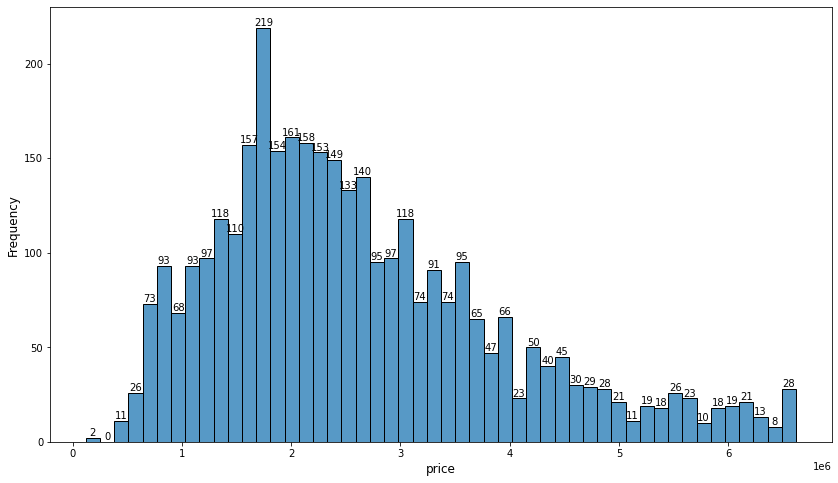

In [58]:
plot_col_distributions(['price'], 'histplot', df = df[is_not_outlier(df.price)], num_subplots = 1, figsize = (14, 8))

<b>Comments</b>

1. Most of the apartments range between 1-3 million shekels, though this certainly will vary by room size.

## Add Features

### Price per square meter

In [59]:
df['ppm'] = df['price'] / df['meters']

#### Distribution

In [60]:
df.ppm.describe()

count    3.739000e+03
mean     2.906687e+04
std      6.760475e+04
min      1.500000e+03
25%      1.735294e+04
50%      2.322835e+04
75%      3.057698e+04
max      2.650000e+06
Name: ppm, dtype: float64

- The outliers are extreme in this case. It does not make sense for an apartment to cost in the millions or hundreds of thousands of shekels per square meter. These will be examined.

In [61]:
df[~is_not_outlier(df.ppm)].sort_values(by = 'ppm', ascending = False).head(10)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city,ppm
930,2650000,Haviva Reik St. Holon,Apartment,4.0,1,1.0,0,Haviva Reik St.,Holon,2.650000e+06
2736,2380000,"Givat HaTahmoshet St. 28,Holon",Apartment,4.0,1,1.0,0,Givat HaTahmoshet St.,Holon,2.380000e+06
276,1600000,Yarden St. Migdal HaEmek,Villa,1.0,1,1.0,0,Yarden St.,Migdal HaEmek,1.600000e+06
460,1120000,Doctor Mordehai veHava Frieman St. Lod,Apartment,3.0,3,1.0,0,Doctor Mordehai veHava Frieman St.,Lod,1.120000e+06
740,2420000,Uzi Hitman St. Ramla,Mini penthouse,4.5,2,12.0,1,Uzi Hitman St.,Ramla,2.016667e+05
3002,11500000,Luz St. Rishon LeTsiyon,Cottage/house,3.0,1,75.0,1,Luz St.,Rishon LeTsiyon,1.533333e+05
1280,32000000,Merkaz Baalei Melaha St. Tel Aviv-Yafo,Duplex,6.0,5,215.0,2,Merkaz Baalei Melaha St.,Tel Aviv-Yafo,1.488372e+05
1904,18000000,"Shlomo Ibn Gabirol St. 116,Tel Aviv-Yafo",Penthouse,4.0,1,127.0,2,Shlomo Ibn Gabirol St.,Tel Aviv-Yafo,1.417323e+05
1296,25000000,Shalag St. Tel Aviv-Yafo,Duplex,4.0,6,180.0,3,Shalag St.,Tel Aviv-Yafo,1.388889e+05
1931,45000000,Sderot Levi Eshkol Tel Aviv-Yafo,Penthouse,5.0,24,330.0,2,Sderot Levi Eshkol,Tel Aviv-Yafo,1.363636e+05


- The first four listings are impossible because they claim to only be 1 meter large. Thus we will drop these listings.

In [62]:
df.drop([930, 2736, 276, 460], axis = 0, inplace = True)

- The apartment in Ramla must have been 120 meters, not 12 meters.

In [63]:
df.loc[740, 'meters'] = 120

In [64]:
df.loc[740, 'ppm'] = df.loc[740, 'price'] / df.loc[740, 'meters']

- Graph including outliers

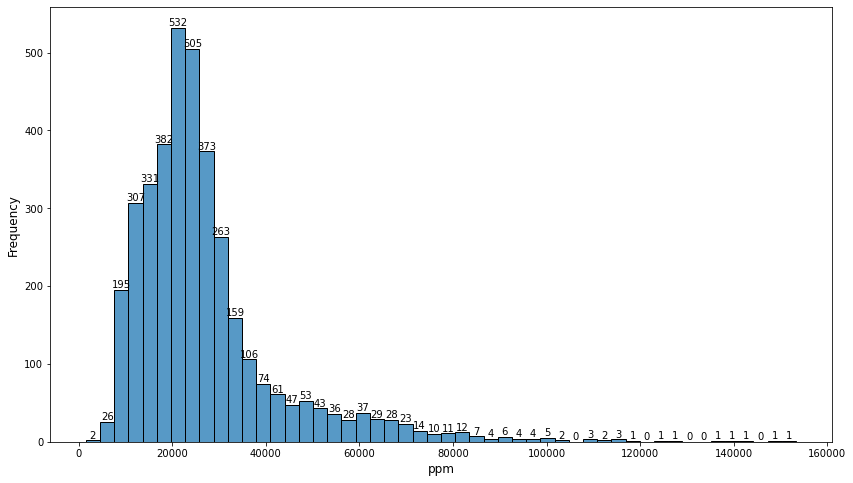

In [65]:
plot_col_distributions(['ppm'], 'histplot', num_subplots = 1, figsize = (14, 8))

- Graph without outliers

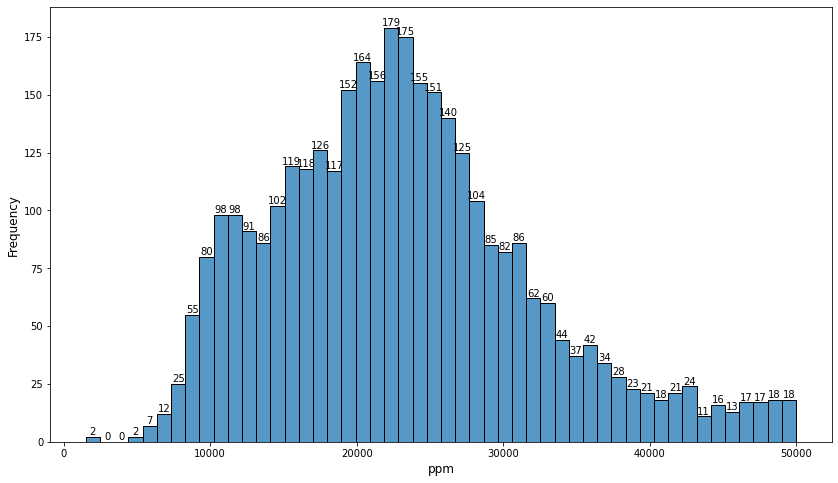

In [66]:
plot_col_distributions(['ppm'], 'histplot', df = df[is_not_outlier(df.ppm)], num_subplots = 1, figsize = (14, 8))

- The PPM is mostly between 20k-30k.
- The upper tail is likely Tel Aviv and the immediate surrounding area.

### Travel to work to arrive by 9 AM

#### Webscraping with Selenium

In [67]:
# browser =  webdriver.Chrome(PATH)
# browser.get(LINK)
# time.sleep(2)  # Allow 5 seconds for the web page to open

In [68]:
# search_bar = browser.find_element("xpath", 
#                                   '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[3]/div[1]/div[1]/div[2]/div[1]/div/input');
# driving_icon = browser.find_element("xpath", '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[2]/div/div/div/div[2]/button/img')
# transit_icon = browser.find_element("xpath", '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[2]/div/div/div/div[3]/button/img')

In [69]:
# address_list = transport_df.address.values
# driving_time_list = []
# transit_time_list = []
# transit_names_list = []

In [70]:
# start = time.time()
# for address in address_list:
#     start = time.time()
#     try:
#         search_bar.clear()
#         search_bar.send_keys(address)
#         time.sleep(2)
#         search_bar.send_keys(Keys.RETURN)
#         time.sleep(2)
#         driving_icon = browser.find_element("xpath", '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[2]/div/div/div/div[2]/button/img')
#         driving_icon.click()
#         time.sleep(2)
#         soup = BeautifulSoup(browser.page_source, "html.parser")
#         driving_time_list.append(soup.find("div", {"class":"Fk3sm fontHeadlineSmall delay-heavy"}).text.strip())
#     except:
#         driving_time_list.append('NA')
#     try:
#         transit_icon.click()
#         time.sleep(2)
#         soup = BeautifulSoup(browser.page_source, "html.parser")
#         transit_time_list.append(soup.find("div", {"class":"XdKEzd"}).text.strip())
#     except:
#         transit_time_list.append('NA')
#     try:
#         transit_names_list.append(soup.find("div", {'class': 'CMnFh'}).text.strip())
#     except:
#         transit_names_list.append('NA')
#     print('=', end = '')
# end = time.time()
# total_time = end - start
# print('\n\n{}min, {:.0f}sec'.format(total_time//60, total_time%60))

In [71]:
# transport_df = pd.DataFrame({'address': address_list, 
#                             'driving_time': driving_time_list,
#                            'public_trans_time': transit_time_list,
#                            'public_trans_option': transit_names_list})

#### Exporting/importing the csv

In [72]:
# transport_df.to_csv('transport_details.csv')

In [73]:
transport_df = pd.read_csv('transport_details.csv')

In [74]:
transport_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [75]:
transport_df.head(2)

,address,driving_time,public_trans_time,public_trans_option
0,Shlomo Kaplanski St. Rishon LeTsiyon,typically 30 min - 1 hr,48 min,190
1,King George St. Tel Aviv-Yafo,typically 9 - 24 min,12 min,8


#### Merging the DataFrames

In [76]:
df['driving_time'] = transport_df.loc[df.index].driving_time
df['public_trans_time'] = transport_df.loc[df.index].public_trans_time
df['public_trans_option'] = transport_df.loc[df.index].public_trans_option

In [77]:
df.head(2)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city,ppm,driving_time,public_trans_time,public_trans_option
0,2790000,Shlomo Kaplanski St. Rishon LeTsiyon,Apartment,5.0,4,125.0,2,Shlomo Kaplanski St.,Rishon LeTsiyon,22320.000000,typically 30 min - 1 hr,48 min,190
1,6000000,King George St. Tel Aviv-Yafo,Apartment,4.0,1,110.0,0,King George St.,Tel Aviv-Yafo,54545.454545,typically 9 - 24 min,12 min,8


#### Check for null values

In [78]:
print('{:.2%} of the driving_time values are null.'.format(df.driving_time.isna().mean()
))

1.15% of the driving_time values are null.


In [79]:
df.driving_time.fillna('NA', inplace = True)

In [80]:
print('{:.2%} of the driving_time values are null.'.format(df.public_trans_time.isna().mean()
))

10.33% of the driving_time values are null.


In [81]:
df.public_trans_time.fillna('NA', inplace = True)

In [82]:
print('{:.2%} of the driving_time values are null.'.format(df.public_trans_option.isna().mean()))

10.68% of the driving_time values are null.


In [83]:
df.public_trans_option.fillna('NA', inplace = True)

#### Cleaning up the columns: extracting min/max driving time to work

In [84]:
def parse_driving_time(string):
    if string == 'NA':
        return np.nan, np.nan
    string = re.sub('typically', '', string).strip()
    str_list = string.split('-')
    min_time = 0
    #Get min time
    if 'hr' in str_list[0]:
        min_lst = str_list[0].strip().split('hr')
        min_time += int(min_lst[0]) * 60
        if 'min' in min_lst[1]:
            min_time +=int(re.sub('min','',min_lst[1]).strip())
    elif 'min' in str_list[0]:
        min_time +=int(re.sub('min','',str_list[0]).strip())
    else:
        if 'hr' in str_list[1]:
            min_time += int(str_list[0].strip())*60
        else:
            min_time += int(str_list[0].strip())
    max_time = 0
    if 'hr' in str_list[1]:
        max_lst = str_list[1].strip().split('hr')
        max_time += int(max_lst[0]) * 60
        if 'min' in max_lst[1]:
            max_time +=int(re.sub('min','',max_lst[1]).strip())
    elif 'min' in str_list[1]:
        max_time +=int(re.sub('min','',str_list[1]).strip())
    return min_time, max_time

In [85]:
min_driving_time, max_driving_time = zip(*df['driving_time'].apply(parse_driving_time))

In [86]:
df['min_driving_time'] = min_driving_time
df['max_driving_time'] = max_driving_time

#### Cleaning up the columns: extracting public transit time to work

In [87]:
def parse_transport_time(string):
    #Get min time
    time = 0
    try:
        if 'hr' in string:
            time_list = string.strip().split('hr')
            time += int(time_list[0]) * 60
            if 'min' in time_list[1]:
                time +=int(re.sub('min','',time_list[1]).strip())
        elif 'min' in string:
            time +=int(re.sub('min','',string).strip())
    except:
        return np.nan
    return time

In [88]:
df['public_trans_time_min'] = df.public_trans_time.apply(parse_transport_time)

In [89]:
def display_distribution_by_city(df, col_name):
    order = df.groupby('city').filter(lambda x: len(x) > 10).groupby(by=["city"])[col_name].median().sort_values().index
    plt.figure(figsize = (16, 8))
    sns.boxplot(x = 'city', 
            y = col_name, 
            data = df.groupby('city').filter(lambda x: len(x) > 10),
           order = order)
    plt.xticks(rotation = 45)
    plt.title(f'Distribution of {col_name} by city')
    plt.show()

In [90]:
def display_col_by_city(df, city, col_name, units):
    print('Median {}: {:.0f} {}\n\nAverage {}: {:.0f} {}\n\nNumber of listings: {}\n'.
          format(col_name,
                 df.loc[df.city == city, col_name].median(),
                 units,
                 col_name,
                 df.loc[df.city == city, col_name].mean(),
                 units,
                 len(df[df.city == city])))
    df.loc[df.city == city, col_name].hist(bins = 30, edgecolor = 'k')
    plt.xlabel(col_name)
    plt.ylabel('Number of Listings')
    plt.show

#### Driving Time to Work (Max)

**Distribution**

In [91]:
print('{:.0%} of the values in the "max_driving_time" column are null.'.format(df.max_driving_time.isna().mean()))

1% of the values in the "max_driving_time" column are null.


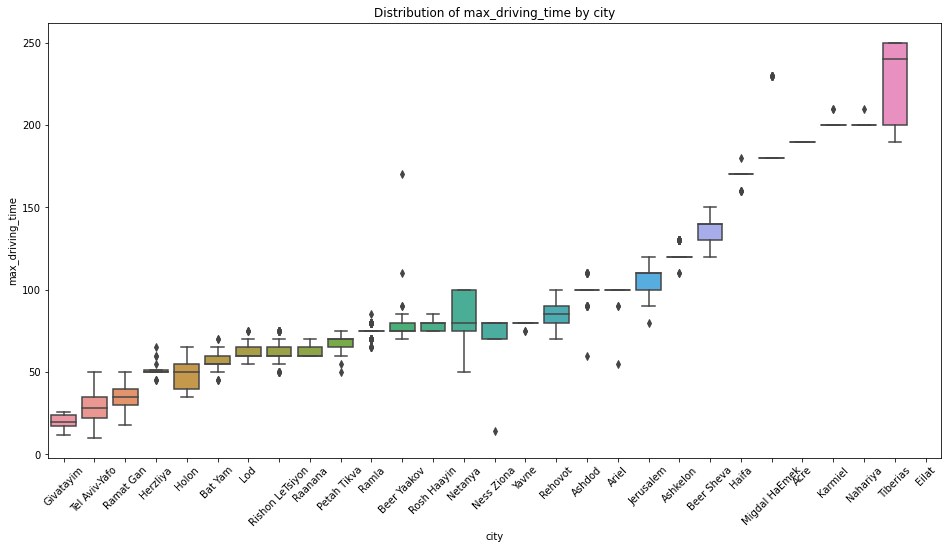

In [92]:
display_distribution_by_city(df, 'max_driving_time')

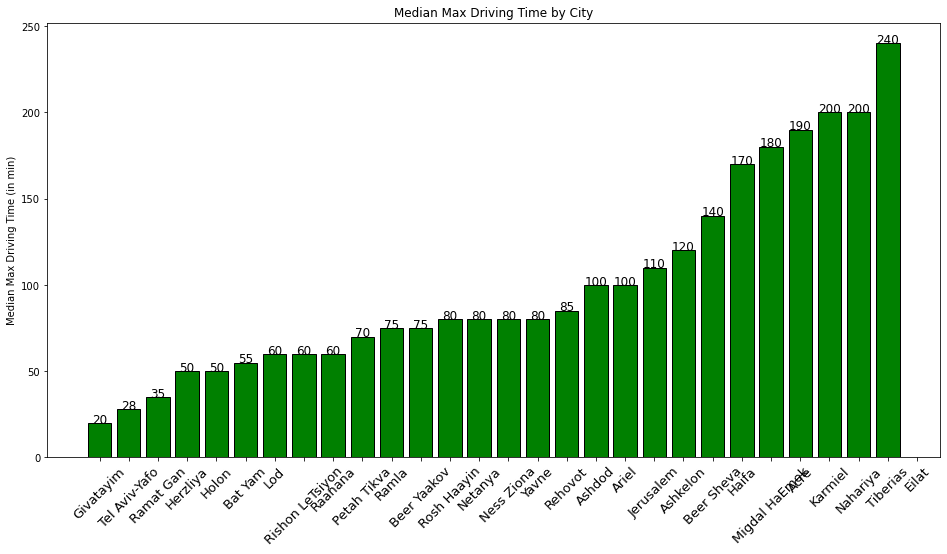

In [93]:
plt.figure(figsize = (16, 8))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('city')['max_driving_time'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'green', edgecolor = 'k')
plt.ylabel('Median Max Driving Time (in min)')
plt.title('Median Max Driving Time by City')
plt.xticks(rotation = 45, fontsize = 13)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- Cities as far as Rehovot are within the most extreme driving time to work that we would be willing to take.
- Rehovot is also the most extreme driving time of cities within the center.

#### Public Transit time to Work

**Distribution**

In [94]:
print('{:.0%} of the values in the "public_trans_time_min" column are null.'.format(df.public_trans_time_min.isna().mean()))

3% of the values in the "public_trans_time_min" column are null.


In [95]:
df[df.public_trans_time_min.isna()].head(2)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city,ppm,driving_time,public_trans_time,public_trans_option,min_driving_time,max_driving_time,public_trans_time_min
30,5480000,HaYarkon St. Tel Aviv-Yafo,New homes,3.0,2,70.0,0,HaYarkon St.,Tel Aviv-Yafo,78285.714286,typically 12 - 35 min,37 min 2.9 km,705,12.0,35.0,NaN
127,6200000,HaYarkon St. Tel Aviv-Yafo,Apartment,4.0,4,94.0,2,HaYarkon St.,Tel Aviv-Yafo,65957.446809,typically 12 - 35 min,37 min 2.9 km,705,12.0,35.0,NaN


- These values will remain null. It must have been an error in webscraping or google could not find the listing.

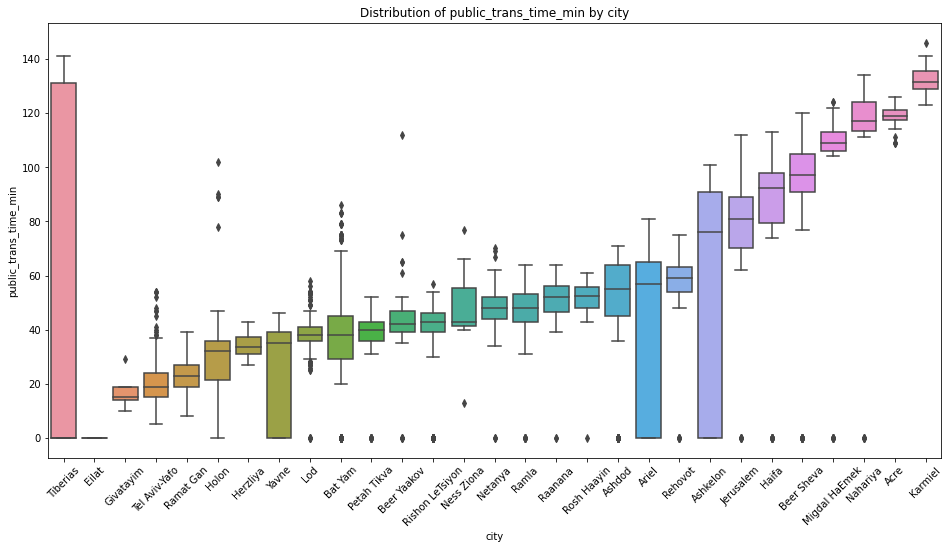

In [96]:
display_distribution_by_city(df, 'public_trans_time_min')

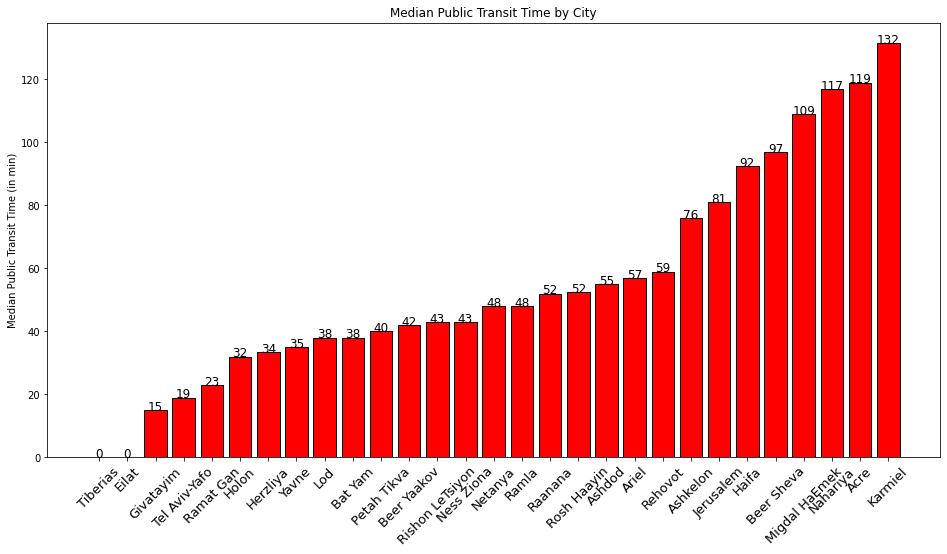

In [97]:
plt.figure(figsize = (16, 8))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('city')['public_trans_time_min'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'red', edgecolor = 'k')
plt.ylabel('Median Public Transit Time (in min)')
plt.title('Median Public Transit Time by City')
plt.xticks(rotation = 45, fontsize = 13)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- Again, Rehovot has the most amount of time on public transit of the central cities.
- Yavne and Lod have surprisingly fast travel times to Tel Aviv.
- Rishon LeTsiyon and Ness Ziona are central cities with a middle range of public transit time.

#### Number of transfers on trip to TLV

In [98]:
def num_trips(string):
    try:
        transport_list = []
        train = ''
        for text in string.split():
            if len(re.findall("[0-9.]", text))!=0:
                transport_list.append(text)
            else:
                train += text
        if train != '':
            transport_list.append(train)
        return len(transport_list)
    except:
        return np.nan

In [99]:
print('{:.0%} of the values in the "public_trans_option" column are null.'.format(df.public_trans_option.isna().mean()))

0% of the values in the "public_trans_option" column are null.


- These values will remain null. It must have been an error in webscraping or google could not find the listing.

In [100]:
df['number_trans_trips'] = df.public_trans_option.apply(num_trips)

**Distribution**

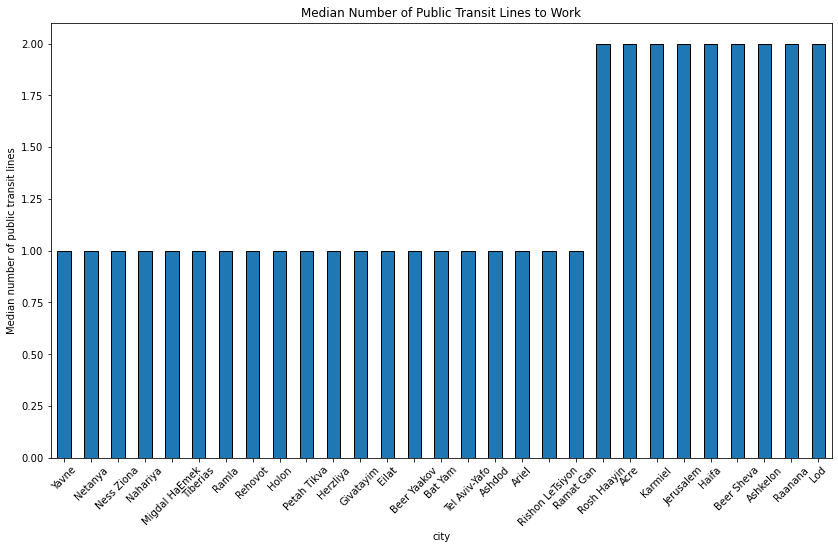

In [101]:
plt.figure(figsize = (14, 8))
df.groupby('city').filter(lambda x: len(x) > 10).groupby('city')['number_trans_trips'].median().sort_values().plot(kind = 'bar', edgecolor = 'k')
plt.xticks(rotation = 45)
plt.title('Median Number of Public Transit Lines to Work')
plt.ylabel('Median number of public transit lines')
plt.show()

- Most cities in the Mercaz have a median number of public transport lines of 1.
- The exception to this is Rehovot and Ra'anana.

### Travel from Parents for gan pick-up (Max)

<b> Extracting Data with Selenium/Beautiful Soup</b>

In [102]:
# browser =  webdriver.Chrome(PATH)
# browser.get(LINK)
# time.sleep(2)  # Allow 5 seconds for the web page to open

In [103]:
# search_bar = browser.find_element("xpath", 
#                                   '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[3]/div[1]/div[2]/div[2]/div[1]/div/input');
# driving_icon = browser.find_element("xpath", '/html/body/div[3]/div[9]/div[3]/div[1]/div[2]/div/div[2]/div/div/div/div[2]/button/img')

In [104]:
# address_list = transport_df.address.values
# driving_time_list = []

In [105]:
# start = time.time()
# for address in address_list:
#     start = time.time()
#     try:
#         search_bar.clear()
#         search_bar.send_keys(address)
#         time.sleep(2)
#         search_bar.send_keys(Keys.RETURN)
#         time.sleep(2)
#         soup = BeautifulSoup(browser.page_source, "html.parser")
#         driving_time_list.append(soup.find("span", {'jstcache':"1092"}).text)
#         # try:
#         #     driving_time_list.append(soup.find("div", {"class":"Fk3sm fontHeadlineSmall delay-heavy"}).text.strip())
#         # except:
#         #     driving_time_list.append(soup.find("div", {"class":"Fk3sm fontHeadlineSmall delay-light"}).text.strip())

#     except:
#         driving_time_list.append('NA')
#     print('=', end = '')
# end = time.time()
# total_time = end - start
# print('\n\n{}min, {:.0f}sec'.format(total_time//60, total_time%60))

In [106]:
# to_parents = pd.DataFrame({'address': address_list, 
#                             'driving_time_to_parents': driving_time_list})

<b>Exporting/Importing the CSV </b>

In [107]:
# to_parents.to_csv('driving_time_to_parents.csv')

In [108]:
to_parents = pd.read_csv('driving_time_to_parents.csv')

In [109]:
df['driving_time_from_parents'] = to_parents.loc[df.index]['driving_time_to_parents']

In [110]:
def parse_driving_time_parents(string):
    try:
        str_list = string.split('-')
        min_time = 0
        #Get min time
        if 'hr' in str_list[0]:
            min_lst = str_list[0].strip().split('hr')
            min_time += int(min_lst[0]) * 60
            if 'min' in min_lst[1]:
                min_time +=int(re.sub('min','',min_lst[1]).strip())
        elif 'min' in str_list[0]:
            min_time +=int(re.sub('min','',str_list[0]).strip())
        else:
            if 'hr' in str_list[1]:
                min_time += int(str_list[0].strip())*60
            else:
                min_time += int(str_list[0].strip())
        max_time = 0
        if 'hr' in str_list[1]:
            max_lst = str_list[1].strip().split('hr')
            max_time += int(max_lst[0]) * 60
            if 'min' in max_lst[1]:
                max_time +=int(re.sub('min','',max_lst[1]).strip())
        elif 'min' in str_list[1]:
            max_time +=int(re.sub('min','',str_list[1]).strip())
    except:
        min_time = np.nan
        max_time = np.nan
    return min_time, max_time

In [111]:
df['driving_time_from_parents_min'], df['driving_time_from_parents_max'] = zip(*df['driving_time_from_parents'].apply(parse_driving_time_parents))

**Distribution**

In [112]:
print('{:.0%} of the values in the "driving_time_from_parents_max" column are null.'.format(df.driving_time_from_parents_max.isna().mean()))

9% of the values in the "driving_time_from_parents_max" column are null.


In [113]:
df[df.driving_time_from_parents_max.isna()].head(2)

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city,ppm,driving_time,public_trans_time,public_trans_option,min_driving_time,max_driving_time,public_trans_time_min,number_trans_trips,driving_time_from_parents,driving_time_from_parents_min,driving_time_from_parents_max
3,5420000,"Yoseftal St. 11,Bat Yam",Rooftop apt.,7.0,4,140.0,1,Yoseftal St.,Bat Yam,38714.285714,typically 24 min - 1 hr,37 min,6 אשקלון-אשקלון<->הרצליה-הרצליה,24.0,60.0,37.0,2,NaN,NaN,NaN
4,3750000,Metula St. Ramat Gan,Penthouse,5.0,7,250.0,3,Metula St.,Ramat Gan,15000.000000,typically 14 - 40 min,30 min,60,14.0,40.0,30.0,1,NaN,NaN,NaN


- These errors must have come when webscraping.

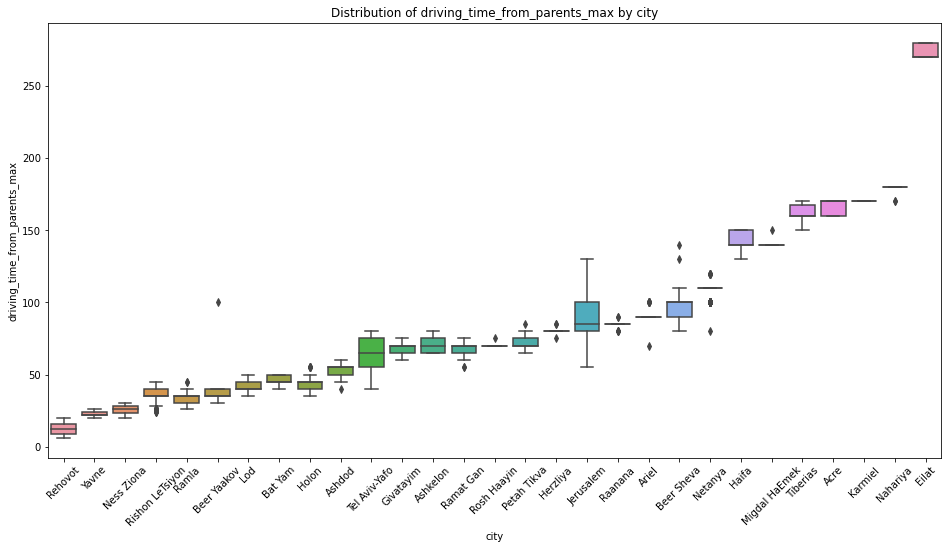

In [114]:
display_distribution_by_city(df, 'driving_time_from_parents_max')

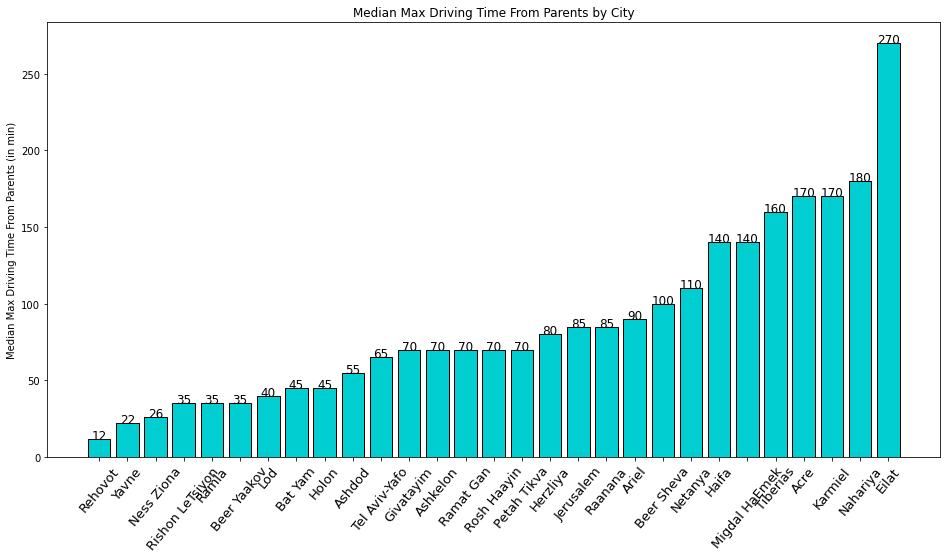

In [115]:
plt.figure(figsize = (16, 8))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('city')['driving_time_from_parents_max'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'darkturquoise', edgecolor = 'k')
plt.ylabel('Median Max Driving Time From Parents (in min)')
plt.title('Median Max Driving Time From Parents by City')
plt.xticks(rotation = 50, fontsize = 13)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- Very obviously, the Eilat and the north is the longest time to get from my parents to the address.
- Jerusalem and Ra'anana also take a very long time.
- Rehovot is of course the shortest travel time from my parents, followed by Yavne, Ness Ziona, and Rishon LeTsiyon.

## Analyze Interaction Between Features

### Cities

#### City vs. price distribution

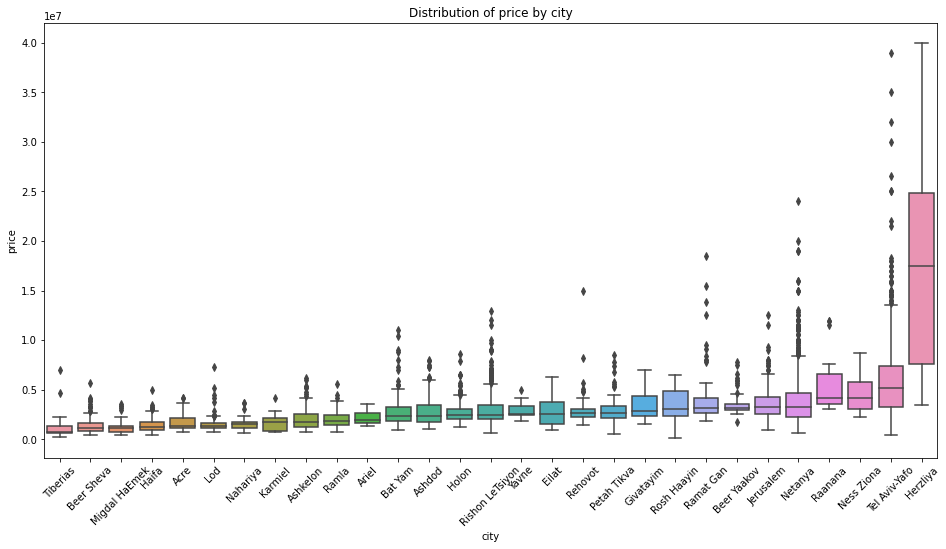

In [116]:
display_distribution_by_city(df[~df.index.isin([df.price.idxmax()])], 'price')

- The city with the most expensive apartments and distribution spread by far is Herzliya. This is followed by Tel Aviv. Herzliya is likely the most expensive as it has a large number of villas. This will be looked at later once PPM is considered.
- The city with the cheapest housing is Tiberias.

**Graph with no outliers for a zoomed in effect.**

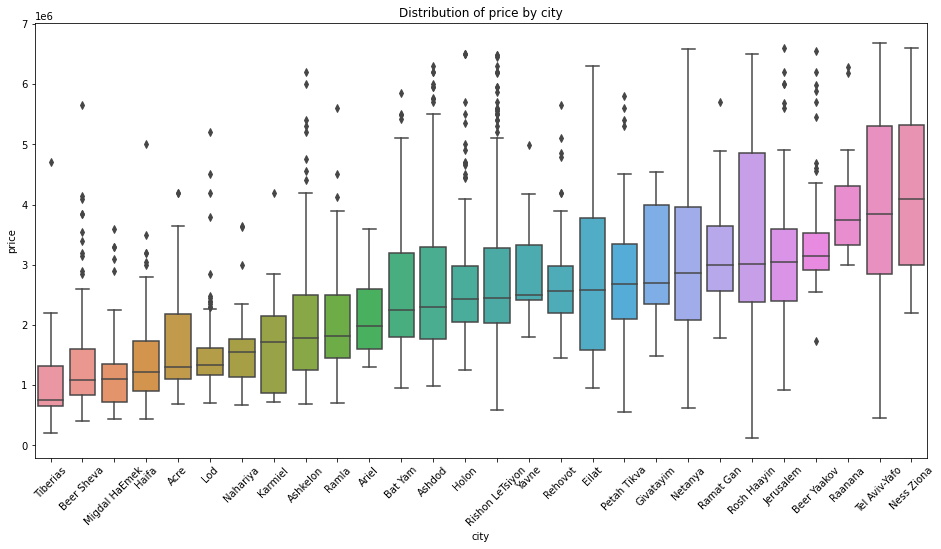

In [117]:
display_distribution_by_city(df[is_not_outlier(df.price)], 'price')

- Surprisingly, without outliers, Ness Ziona is the most expensive place to live.

#### City vs. median price.

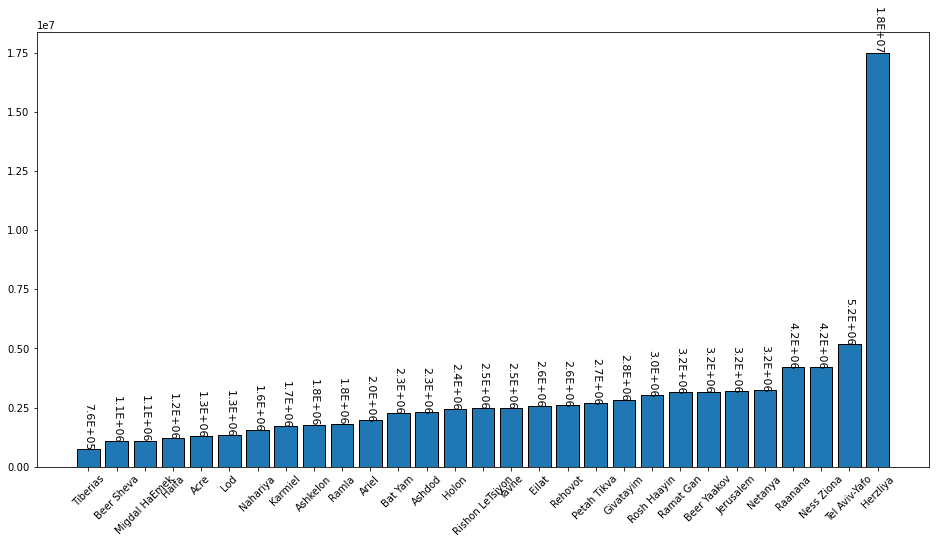

In [118]:
plt.figure(figsize = (16, 8))
labels = df.groupby('city').filter(lambda x: len(x) > 10).groupby('city')['price'].median().sort_values().index
sizes = df.groupby('city').filter(lambda x: len(x) > 10).groupby('city')['price'].median().sort_values().values
plt.bar(labels, sizes, edgecolor = 'k')
for i in range(len(sizes)):
    plt.annotate(format(sizes[i],'.1E'), 
                 xy=(labels[i],sizes[i]), fontsize = 11, ha = 'center', rotation = 270)
plt.xticks(rotation = 45)
plt.show()

- Median price, when outliers are considered, is highest in Herzliya, followed by Tel Aviv and Ness Ziona

### Parking

#### Percent of parking vs. city

In [119]:
df['parking?'] = df.parking.apply(lambda x: 'yes' if x >=1 else 'no')

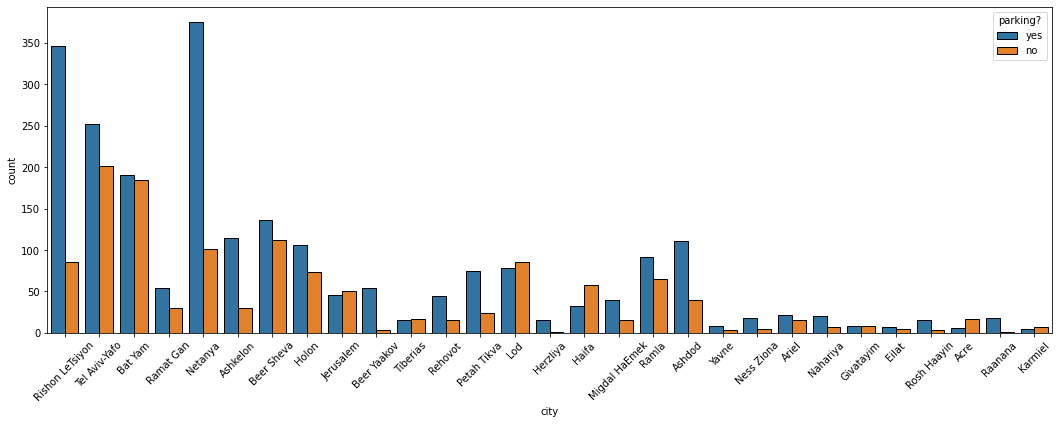

In [120]:
plt.figure(figsize = (18, 6))
sns.countplot(data = df.groupby('city').filter(lambda x: len(x)>=10), x = 'city', hue = 'parking?', edgecolor = 'k')
plt.xticks(rotation = 45)
plt.show()

- The majority of cities have more places with parking than not.
- Rishon LeTsiyon and Netanya have the greatest proportion of places with parking.

#### Parking vs. price (holding other things constant)

In [121]:
def parking_vs_price(city, num_rooms):
    price_with_parking = df[(df.city == city) & (df.num_rooms == num_rooms)& (df['parking?'] == 'yes')]['price'].mean()
    price_no_parking = df[(df.city == city) & (df.num_rooms == num_rooms)& (df['parking?'] == 'no')]['price'].mean()
    print('\nPrice is {:.0%} more expensive {} room apartments in {}\n'.format(price_with_parking/price_no_parking, num_rooms, city))
    parking_price = df[(df.city == city) & (df.num_rooms == num_rooms)].groupby('parking?')['price'].mean().plot(kind = 'bar', edgecolor = 'k')
    plt.title(f'Price by parking for {num_rooms} room apartments in {city}')
    plt.xticks(rotation = 0)
    plt.ylabel('Price in NIS')
    plt.show()
    

In [122]:
interact(parking_vs_price,
        city = df.city.unique(),
        num_rooms = [1, 2, 3, 4, 5])

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Tel Aviv-Yafo', 'Bat Yam', 'Ra…

<function __main__.parking_vs_price(city, num_rooms)>

- Price is always higher for apartments with parking

### Floor Number

#### Floor num vs. price

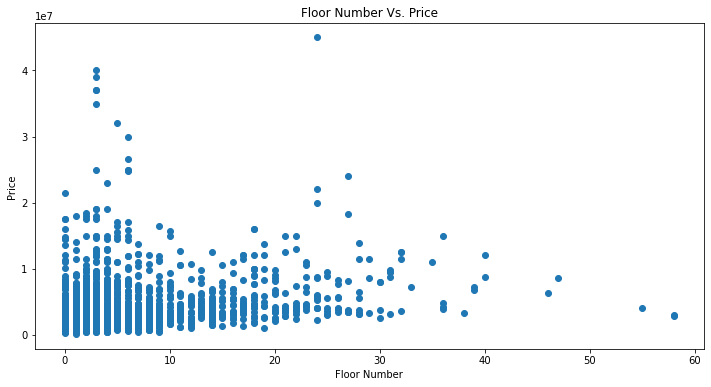

In [123]:
plt.figure(figsize = (12, 6))
plt.scatter(x = df.floor_num, y = df.price)
plt.xlabel('Floor Number')
plt.ylabel('Price')
plt.title('Floor Number Vs. Price')
plt.show()

- There are more expensive apartments on lower floors. This is probably because the high rise buildings tend to be in new developing areas.

### Number of rooms

#### Number of rooms by property type

In [124]:
def display_rooms_property_type(property_type):
    plt.figure(figsize = (12, 6))
    df[df.property_type == property_type]['num_rooms'].value_counts(normalize = True).plot(kind = 'bar', edgecolor = 'k')
    plt.title(f'Number of Rooms for {property_type}')
    plt.xticks(rotation = 0)
    plt.xlabel('Number of Rooms')
    plt.ylabel('Percentage')
    plt.show()

In [125]:
interact(display_rooms_property_type,
          property_type = df.property_type.unique())

interactive(children=(Dropdown(description='property_type', options=('Apartment', 'Rooftop apt.', 'Penthouse',…

<function __main__.display_rooms_property_type(property_type)>

- Most apartments have 4 rooms (then 3, then 5).
- Most penthouses have 5 rooms.
- Most cottages have 6 rooms.

#### Number of meters by number of rooms

In [126]:
df['meters_per_room'] = df.meters / df.num_rooms

In [127]:
order = df.groupby('city').filter(lambda x: len(x) > 10).groupby(by=["city"])['meters_per_room'].median().sort_values(ascending = False).index

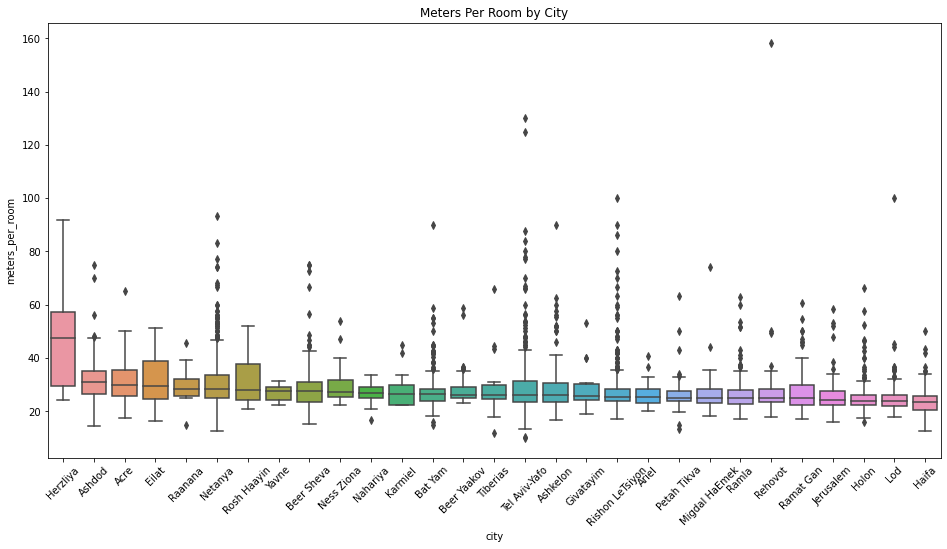

In [128]:
plt.figure(figsize = (16, 8))
sns.boxplot(x = 'city', 
            y = 'meters_per_room', 
            data = df.groupby('city').filter(lambda x: len(x) > 10),
           order = order)
plt.title('Meters Per Room by City')
plt.xticks(rotation = 45)
plt.show()

- Most apartments have a median of around 25-30 meters per room.
- Hreziliya is the exception. It is the most spacious. This is likely because there are a lot of villas in Herzliya.
- Tel Aviv, Rishon, and Netanya have the most outlying apartments in terms of spaciousness.

### Meters

#### Meters vs. property type

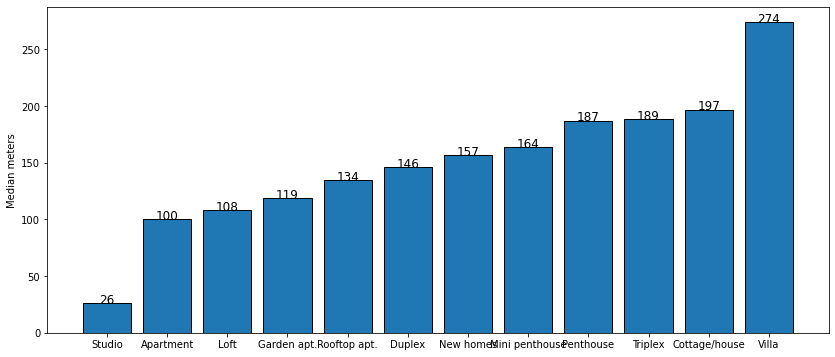

In [129]:
plt.figure(figsize = (14, 6))
sizes = df.groupby('property_type')['meters'].mean().sort_values().values
labels = df.groupby('property_type')['meters'].mean().sort_values().index
plt.bar(labels, sizes, edgecolor = 'k')
plt.ylabel('Median meters')
plt.xticks(rotation = 0)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- Apartments have a median size of 100m, which is great for our purposes.

#### Meters vs. price

In [130]:
no_outlying_price_meters = df[~df.index.isin([df.meters.idxmax(),df.price.idxmax()])]

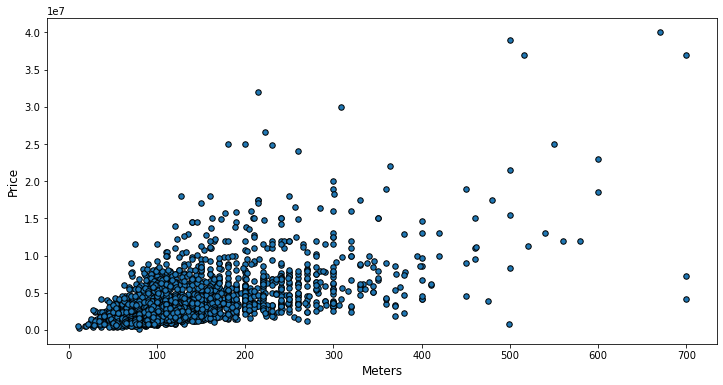

In [131]:
plt.figure(figsize = (12,6))
plt.scatter(x = no_outlying_price_meters.meters, y=no_outlying_price_meters.price,edgecolor = 'k', s = 30)
plt.xlabel('Meters', fontsize = 12)
plt.ylabel('Price', fontsize = 12)
plt.show()

- There is a small positive correlation between meters and price. There are many other factors to take into considerion though, such as location, the status of its renovations, etc.

#### Meters vs. city

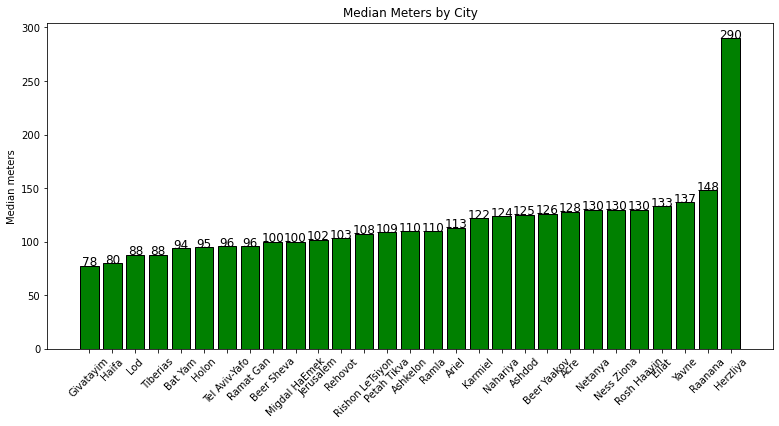

In [132]:
plt.figure(figsize = (13, 6))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('city')['meters'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'green', edgecolor = 'k')
plt.ylabel('Median meters')
plt.title('Median Meters by City')
plt.xticks(rotation = 45)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- We are looking for a place for over 100 meters.
- Rehovot, Rishon LeTsiyon, Ness Tsiyona, Beer Yaakov seem like good options. Also Ra'anana and Ness Ziona

### Price

#### Price distributions by room size.

In [133]:
order = data = df.groupby('num_rooms')['price'].median().sort_values().index

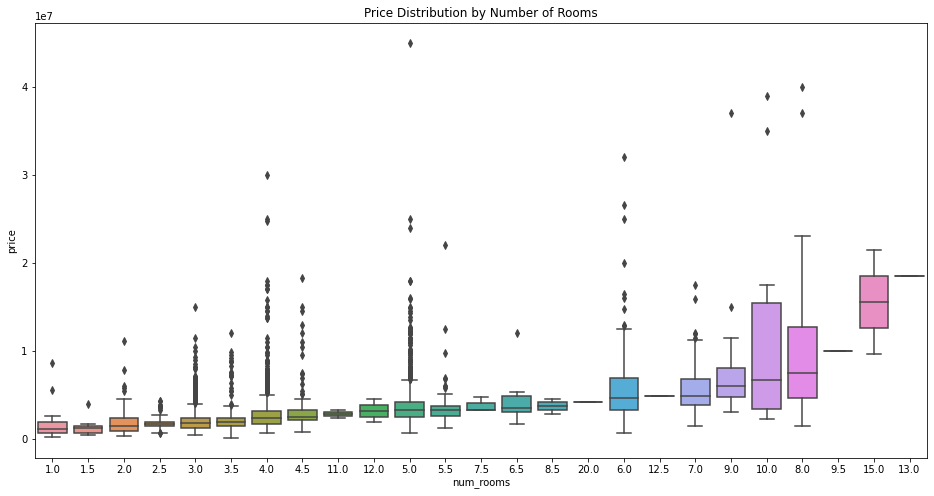

In [134]:
plt.figure(figsize = (16, 8))
sns.boxplot(x = 'num_rooms', 
            y = 'price', 
            data = df,
           order = order)
plt.xticks(rotation = 0)
plt.title('Price Distribution by Number of Rooms')
plt.show()

- The graph above clearly has a lot of outliers, which makes it hard to see details. We will zoom in without outliers below.

In [135]:
order = df[is_not_outlier(df.price)].groupby('num_rooms')['price'].median().sort_values().index

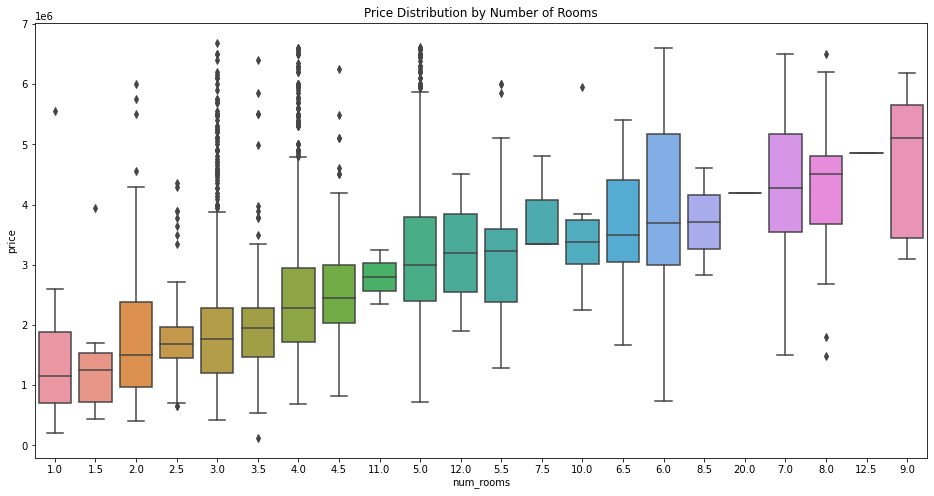

In [136]:
plt.figure(figsize = (16, 8))
sns.boxplot(x = 'num_rooms', 
            y = 'price', 
            data = df[is_not_outlier(df.price)],
           order = order)
plt.xticks(rotation = 0)
plt.title('Price Distribution by Number of Rooms')
plt.show()

- As expected, the distribution of prices increases when the number of rooms increases. 
- 5 and 6 bedroom places have the largest spread in prices. This must depend on where the places are located. Also, it may be determined by the property type, such as if the listing is a villa or penthouse.
- 1.5 bedroom apartments have the smallest spread. Surprisingly there is only 1 above 2 million.
- 11 room apartments are surprisngly very cheap, though we are likely working with a small samples size of these.
- 4 room apartments, which is what we are searching for, have quite a large spread in price as well.

#### Price by property type

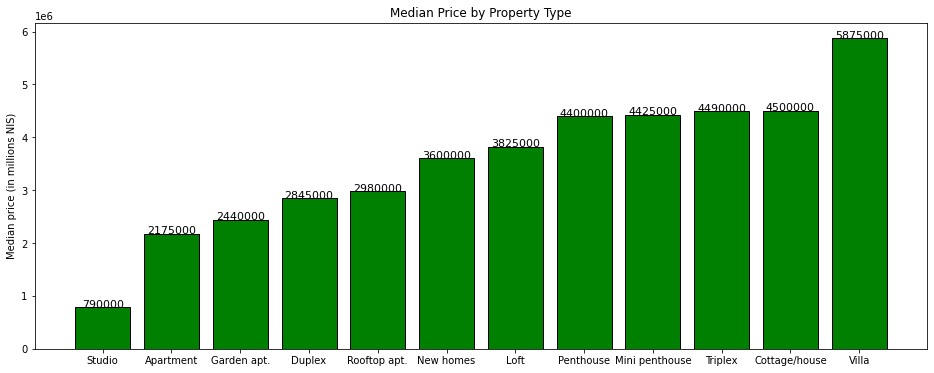

In [137]:
plt.figure(figsize = (16, 6))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('property_type')['price'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'green', edgecolor = 'k')
plt.ylabel('Median price (in millions NIS)')
plt.title('Median Price by Property Type')
plt.xticks(rotation = 0)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 11, ha = 'center')
plt.show()

- The median apartment price (regardless of room numbers)is around 2.2 million.
- The median cottage price is near 6 million.
- The median house price is around 4.5 million.

### Price Per Square Meter

#### PPM Based on City

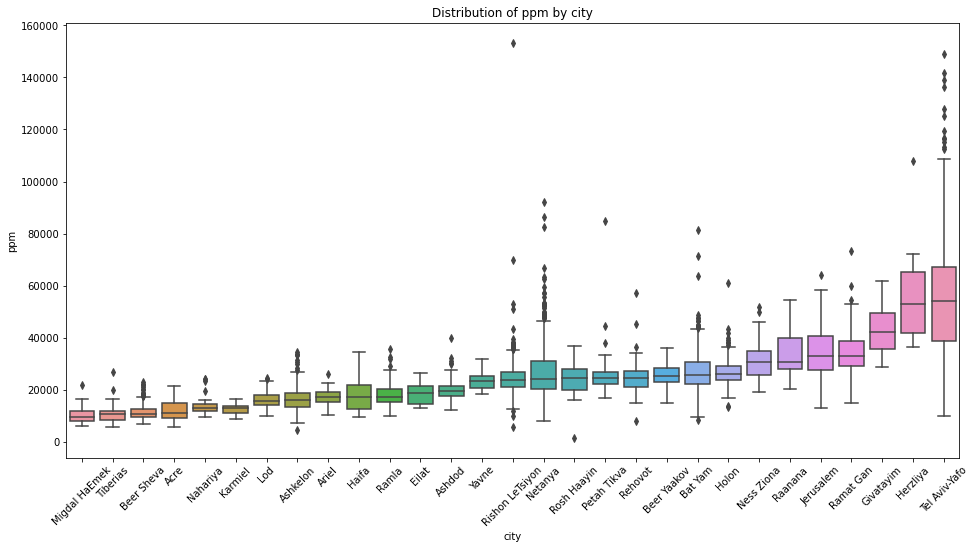

In [138]:
display_distribution_by_city(df, 'ppm')

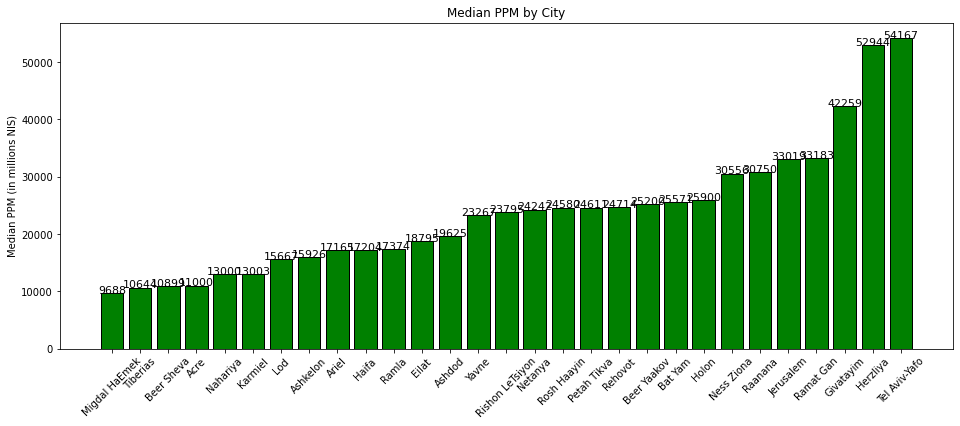

In [139]:
plt.figure(figsize = (16, 6))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('city')['ppm'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'green', edgecolor = 'k')
plt.ylabel('Median PPM (in millions NIS)')
plt.title('Median PPM by City')
plt.xticks(rotation = 45)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 11, ha = 'center')
plt.show()

- Price per square meter is the most expensive in Tel Aviv and least expensive in Migdal HaEmek

#### PPM Based on property type

In [140]:
order = df.groupby('property_type')['ppm'].median().sort_values().index

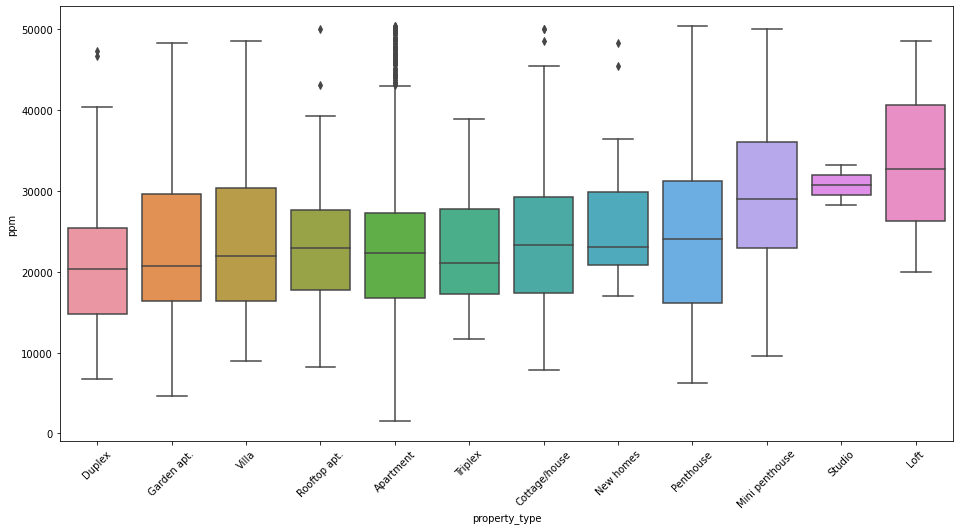

In [141]:
plt.figure(figsize = (16, 8))
sns.boxplot(x = 'property_type', 
            y = 'ppm', 
            data = df.groupby('city').filter(lambda x: len(x) > 10)[is_not_outlier(df.groupby('city').filter(lambda x: len(x) > 10).ppm)],
           order = order)
plt.xticks(rotation = 45)
plt.show()

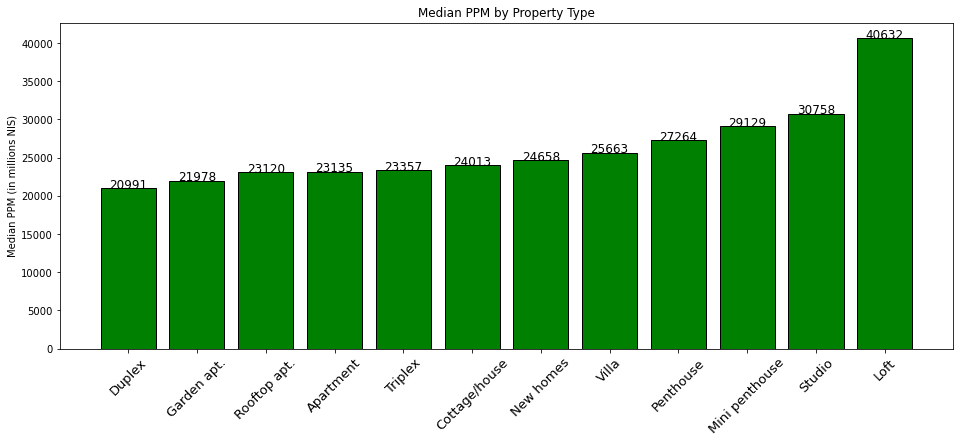

In [142]:
plt.figure(figsize = (16, 6))
y_vals = df.groupby('city').filter(lambda x: len(x)>=10).groupby('property_type')['ppm'].median().sort_values()
sizes = y_vals.values
labels = y_vals.index
plt.bar(labels, sizes, color = 'green', edgecolor = 'k')
plt.ylabel('Median PPM (in millions NIS)')
plt.title('Median PPM by Property Type')
plt.xticks(rotation = 45, fontsize = 13)
for i in range(len(sizes)):
    plt.annotate('{:.0f}'.format(sizes[i]), 
                 xy=(labels[i],sizes[i]), fontsize = 12, ha = 'center')
plt.show()

- Penthouses, lofts, and studios cost more per square meter than any of the other types

### Driving time to parents

#### Relationship with price

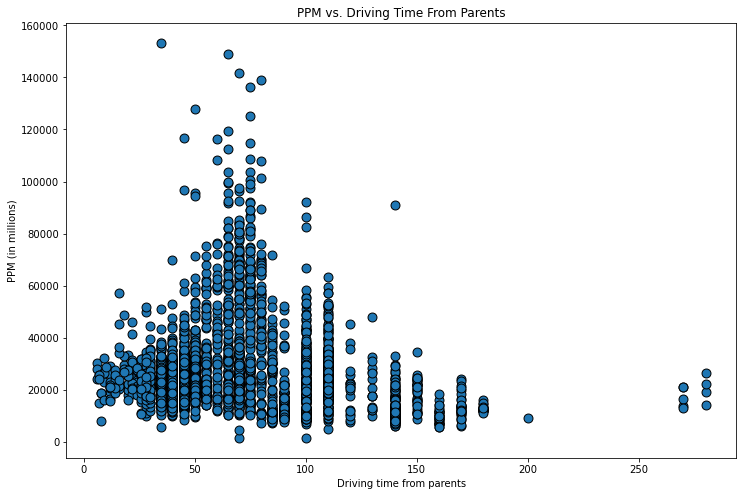

In [143]:
plt.figure(figsize = (12, 8))
plt.scatter(df.driving_time_from_parents_max, df.ppm, edgecolor = 'k', s = 80)
plt.xlabel('Driving time from parents')
plt.ylabel('PPM (in millions)')
plt.title('PPM vs. Driving Time From Parents')
plt.show()

- The PPM is most expensive between 50-100 min of driving time from my parents. This is likely because this is approximately the rush hour driving time to TLV.

### Public trans time to work

#### Relationship with price

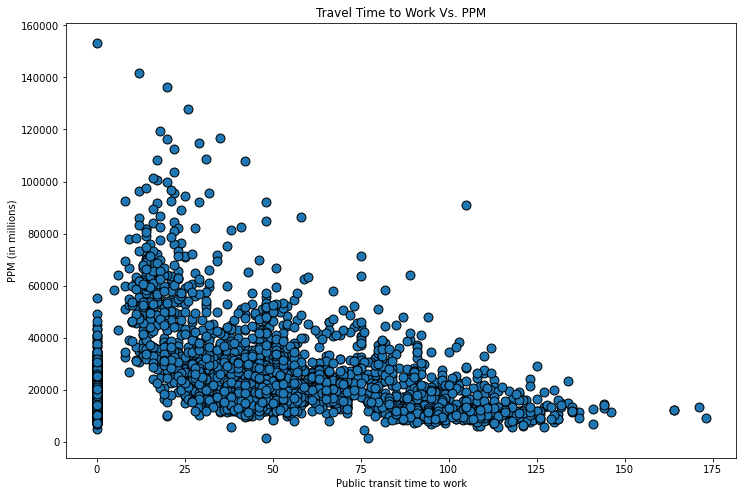

In [144]:
plt.figure(figsize = (12, 8))
plt.scatter(df.public_trans_time_min, df.ppm, edgecolor = 'k', s = 80)
plt.xlabel('Public transit time to work')
plt.ylabel('PPM (in millions)')
plt.title('Travel Time to Work Vs. PPM')
plt.show()

- The PPM is more expensive the closer we are to work. Though there are outliers in the data around 40 minutes. Perhaps these are in Herziliya parts of northern Tel Aviv.

### Driving time to work

#### Relationship with price

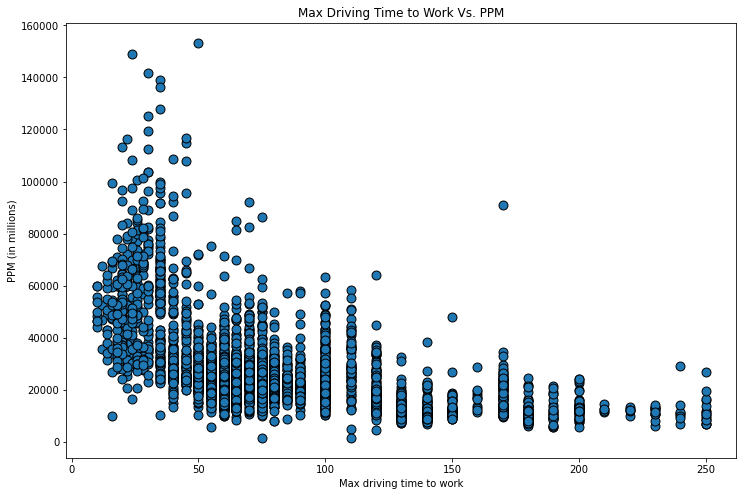

In [145]:
plt.figure(figsize = (12, 8))
plt.scatter(df.max_driving_time, df.ppm, edgecolor = 'k', s = 80)
plt.xlabel('Max driving time to work')
plt.ylabel('PPM (in millions)')
plt.title('Max Driving Time to Work Vs. PPM')
plt.show()

- The shorter the drive to work, the more expensive the apartment is. This is logical, because places near Tel Aviv tend to be the most expensive.

# Selecting the Optimal Neighborhoods

## By Filtering

Criteria:
- Max price < 3,000,000
- Min Number of rooms = 4
- Min meters = 100
- Parking = 'yes'
- Max driving time to work = 90 minutes
- Max public trans time to work = 60 minutes
- Max number of public transit trips = 1
- Max driving time from parents = 45 minutes

In [146]:
def filter_listings(df, max_price, min_num_rooms, min_meters,
                    parking, max_driving_time, max_public_trans_time,
                   number_trans_trips, max_driving_time_from_parents):
    filtered_df = df[(df.price<=max_price)&
                    (df.num_rooms >= min_num_rooms)&
                    (df.meters>=min_meters)&
                    (df['parking?'] == parking)&
                    (df.max_driving_time<=max_driving_time)&
                    (df.public_trans_time_min<=max_public_trans_time)&
                    (df.number_trans_trips==number_trans_trips)&
                    (df.driving_time_from_parents_max<=max_driving_time_from_parents)]
    plt.figure(figsize = (10, 6))
    labels_1 = filtered_df.city.value_counts().index
    sizes_1 = filtered_df.city.value_counts().values
    plt.bar(labels_1, sizes_1, color = 'green', edgecolor = 'k')
    for i in range(len(sizes_1)):
        plt.annotate('{:.0f}'.format(sizes_1[i]), 
                     xy=(labels_1[i],sizes_1[i]), fontsize = 11, ha = 'center')
    plt.ylabel('Number of Listings')
    plt.title('Number of Listings by City')
    plt.xticks(rotation = 30)
    plt.show()
    plt.figure(figsize = (10, 6))
    
    percentage_of_listings = filtered_df.city.value_counts().sort_index()/df[df.city.isin(filtered_df.city.value_counts().index)].city.value_counts().sort_index()
    labels_2 = percentage_of_listings.sort_values(ascending = False).index
    sizes_2 = percentage_of_listings.sort_values(ascending = False).values
    plt.bar(labels_2, sizes_2, color = 'red', edgecolor = 'k')
    for i in range(len(sizes_2)):
        plt.annotate('{:.0%}'.format(sizes_2[i]), 
                     xy=(labels_2[i],sizes_2[i]), fontsize = 11, ha = 'center')
    plt.ylabel('Percentage of City Listings')
    plt.title('Percentage of City Listings Meeting Criteria')
    plt.xticks(rotation = 30)
    plt.show()
    return filtered_df

In [147]:
interact(filter_listings,
        df = fixed(df),
        max_price = IntSlider(min=1000000, max=10000000, step = 100000),
        min_num_rooms = IntSlider(min=1, max=10, value=10),
        min_meters = IntSlider(min=20, max=500, step = 10),
        parking = df['parking?'].unique(),
        max_driving_time = IntSlider(min=df.max_driving_time.min(), max=200, step = 5),
        max_public_trans_time = IntSlider(min=df.public_trans_time_min.min(), max=200, step = 5),
        number_trans_trips = df.number_trans_trips.unique(),
        max_driving_time_from_parents = IntSlider(min=0, max=200, step = 5))

interactive(children=(IntSlider(value=1000000, description='max_price', max=10000000, min=1000000, step=100000…

<function __main__.filter_listings(df, max_price, min_num_rooms, min_meters, parking, max_driving_time, max_public_trans_time, number_trans_trips, max_driving_time_from_parents)>

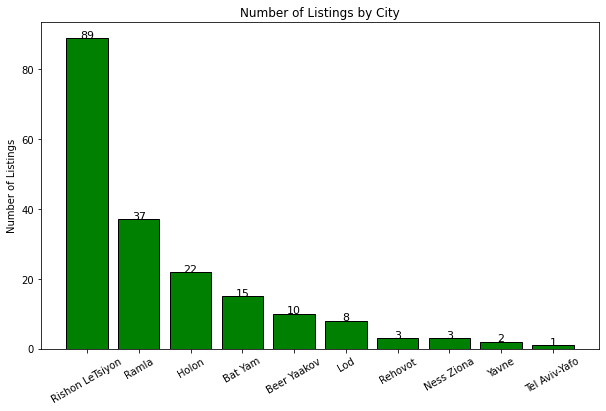

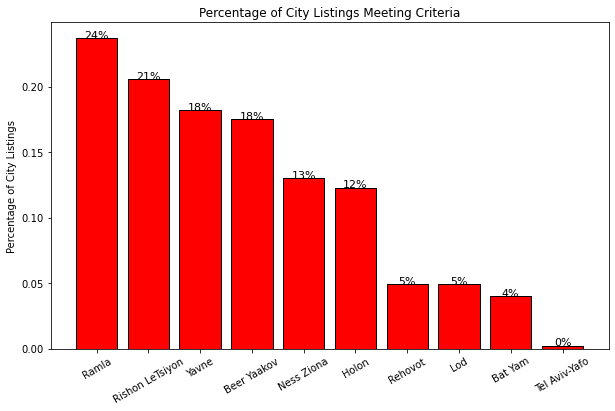

In [148]:
filtered_df = filter_listings(df, max_price = 3000000, min_num_rooms = 4, min_meters = 100,
                    parking = 'yes', max_driving_time = 90, max_public_trans_time = 60,
                   number_trans_trips = 1, max_driving_time_from_parents = 45)

- Surprisingly Tel Aviv has an option.
- Rishon LeTsiyon has the most listings that meet the criteria, while Ramla has the largest percentage of its listings that meet the criteria.
- Other options are Beer Yaakov, Ness Ziona, Holon, Bat Yam, and Rehovot

In [149]:
filtered_df[filtered_df.city == 'Tel Aviv-Yafo']

,price,address,property_type,num_rooms,floor_num,meters,parking,street,city,ppm,...,public_trans_option,min_driving_time,max_driving_time,public_trans_time_min,number_trans_trips,driving_time_from_parents,driving_time_from_parents_min,driving_time_from_parents_max,parking?,meters_per_room
1947,2980000,"Lehi Road 36,Tel Aviv-Yafo",Apartment,4.0,2,106.0,1,Lehi Road 36,Tel Aviv-Yafo,28113.207547,...,7,10.0,20.0,17.0,1,26 - 45 min,26.0,45.0,yes,26.5


## Hierarchical Clustering

In [150]:
clustering_cols = ['city','price', 'num_rooms', 
                   'floor_num', 'meters', 
                   'parking', 'ppm',
                  'max_driving_time', 'public_trans_time_min',
                  'number_trans_trips', 'driving_time_from_parents_max', 'meters_per_room']

In [151]:
df_clustering = df[clustering_cols]

In [152]:
min_num_listings = 5

In [153]:
df_hier_clustering = df_clustering.groupby('city').filter(lambda x: len(x)>= min_num_listings).dropna(axis = 0).groupby('city').mean()


In [154]:
for col in df_hier_clustering.columns:
    df_hier_clustering[col] = (df_hier_clustering[col] - df_hier_clustering[col].min())/ (df_hier_clustering[col].max() - df_hier_clustering[col].min())

In [155]:
lnk = hierarchy.linkage(df_hier_clustering.values, method='ward',metric='euclidean',optimal_ordering=True)

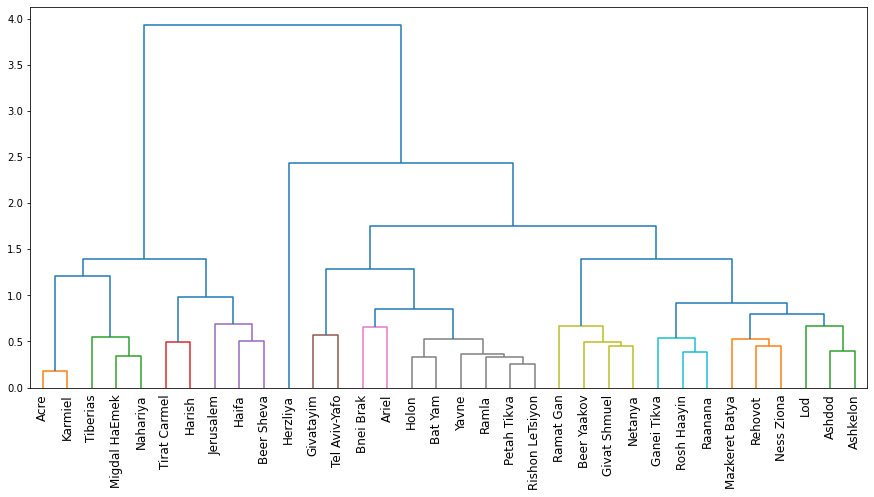

In [156]:
plt.figure(figsize=(15,7))

hierarchy.dendrogram(lnk, 
                     labels=df_hier_clustering.index, 
                     leaf_font_size=12, 
                     color_threshold=0.7,
                     orientation='top',
                     count_sort=True,
                     distance_sort=True,
                     show_leaf_counts=True)
plt.xticks(rotation = 90)
plt.show()

- The clustering method seems to split the cities between the periphery of Israel and the center.
- Since Rishon LeTsiyon was a viable option, we will look at similar cities:
1. Beer Yaakov
2. Rehovot
3. Ness Ziona
4. Bat Yam
5. Holon

In [157]:
relevant_cities = ['Rishon LeTsiyon',
                   'Beer Yaakov',
                   'Rehovot',
                   'Ness Ziona',
                   'Bat Yam',
                   'Holon']

# Analyzing the Chosen Cities

## Price by City

In [158]:
interact(display_col_by_city,
        df = fixed(df.sort_values(by = 'price')),
        city = relevant_cities,
        col_name = fixed('price'),
        units = fixed('nis'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Most of the listings in Rishon, Holon are in our price range.
- A few of the places in Bat Yam are in the 4 mill range. These are probably the larger apartments, but Bat Yam is still a viable option.
- Beer Yaakov is generally in the 3mill and up range. This is too expensive for us. Therefore, we will not search there.
- Rehovot has been expensive places, but also many that are within our price range.
- Ness Ziona has some apartments withon our range, however the median price is very expensive.

## PPM by City

In [159]:
interact(display_col_by_city,
        df = fixed(df),
        city = relevant_cities,
        col_name = fixed('ppm'),
        units = fixed('NIS/m'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Rishon, Holon, Bat Yam, Beer Yaakov, and Rehovot have reasonable PPM. This is almost more important to take into consideration than price.
- Ness Ziona's PPM is very high.

## Property Type by City

In [160]:
def display_property_type_city(city):
    plt.figure(figsize = (14, 6))
    df[df.city == city].property_type.value_counts(normalize = True).plot(kind = 'bar', edgecolor = 'k')
    plt.xticks(rotation = 30, fontsize = 12)
    plt.ylabel('Percentage', fontsize = 13)
    plt.yticks(fontsize = 12)
    plt.title(f'Percentage by property type in {city}')
    plt.show()

In [161]:
interact(display_property_type_city,
        city = relevant_cities)

- All of the cities (except Ness Ziona) have more or less the same distribution of property types.
- Ness Ziona has a very high percentage of cottages/houses. This is likely why its PPM is high.

## Max Driving Time From Parents by City

In [162]:
interact(display_col_by_city,
        df = fixed(df),
        city =relevant_cities,
        col_name = fixed('driving_time_from_parents_max'),
        units = fixed('min'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Bat Yam and Holon have much longer driving times to my parents' house than the other cities. This makes them less appealing.

## Min Driving Time From Parents by City

In [163]:
interact(display_col_by_city,
        df = fixed(df),
        city = relevant_cities,
        col_name = fixed('driving_time_from_parents_min'),
        units = fixed('min'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Same comments as above.

## Max Driving Time to Work by City

- Inspect the distributions of max travel times for each city.

In [164]:
interact(display_col_by_city,
        df = fixed(df.sort_values(by = 'max_driving_time')),
        city = relevant_cities,
        col_name = fixed('max_driving_time'),
        units = fixed('min'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Rishon LeTsiyon has one of the best when it comes to driving time to work (after Holon and Bat Yam)
- Beer Yaakov, Rehovot, and Ness Ziona take quite awhile.

## Number of Transit Lines to Work by City

In [165]:
interact(display_col_by_city,
        df = fixed(df),
        city = relevant_cities,
        col_name = fixed('number_trans_trips'),
        units = fixed('trip(s)'))

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_col_by_city(df, city, col_name, units)>

- Most places in Rehovot require more than one mode of transportation, making it not as undesirable.
- Rishon, Bat Yam, and Holon mostly require only one mode of transportation.

## Price distributions by room size and City.

In [166]:
def display_price_neighborhood_num_rooms(city):
    plt.figure(figsize = (14, 6))
    sns.boxplot(data = df[(df.city == city)], x = 'num_rooms', y = 'price')

In [167]:
interact(display_price_neighborhood_num_rooms,
        city = relevant_cities)

interactive(children=(Dropdown(description='city', options=('Rishon LeTsiyon', 'Holon', 'Bat Yam', 'Beer Yaako…

<function __main__.display_price_neighborhood_num_rooms(city)>

- Most of the 4 and 4.5 bedroom apartments in Rishon, Holon, and Rehovot are under 3 million.
- Bat Yam has some apartments within our range, but many that are too expensive.
- Beer Yaakov is rather expensive for 4 bedroom apartments.
- Ness Ziona is mostly out of our price range for 4 bedroom apartments.

In [168]:
df.to_csv('tableau_housing.csv')

# Final Conclusion

- With all of the above considerings, Rishon LeTsiyon seems to be the best option.